In [1]:
!pip install yfinance arch tensorflow scikit-learn matplotlib

# Read data

In [2]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# S&P 500 (2000 - 2025)



In [3]:
# --- Download S&P 500 Data ---
ticker = '^GSPC'
data = yf.download(ticker, start= '2000-01-03', end= '2023-12-31', auto_adjust=True)

data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
returns = data['LogReturn'] * 100 # percentage returns

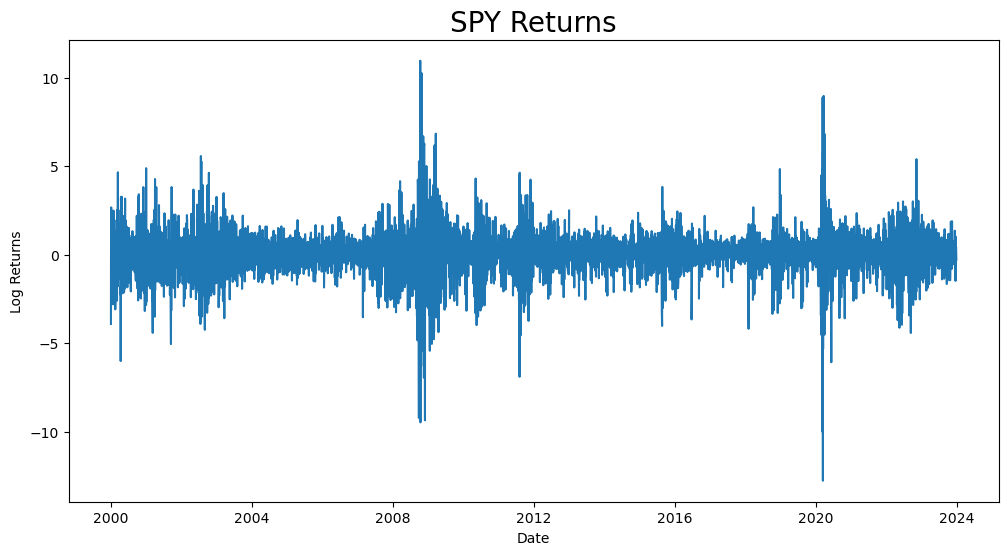

In [5]:
plt.figure(figsize=(12,6))
plt.plot(returns)
plt.ylabel('Log Returns', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.title('SPY Returns', fontsize=20)
plt.show()

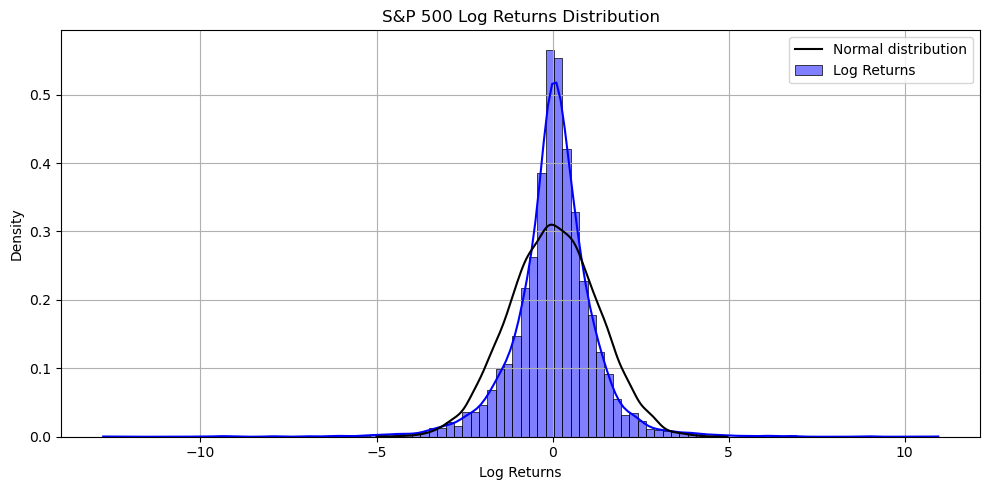

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=100, kde=True, stat='density', color='blue', label='Log Returns')
sns.kdeplot(np.random.normal(returns.mean(), returns.std(), size=10000), color='black', label='Normal distribution')
plt.title('S&P 500 Log Returns Distribution')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Volatility

In [7]:
# Rolling 22-day volatility (not annualized)
volatility = returns.rolling(window=22).std().dropna()

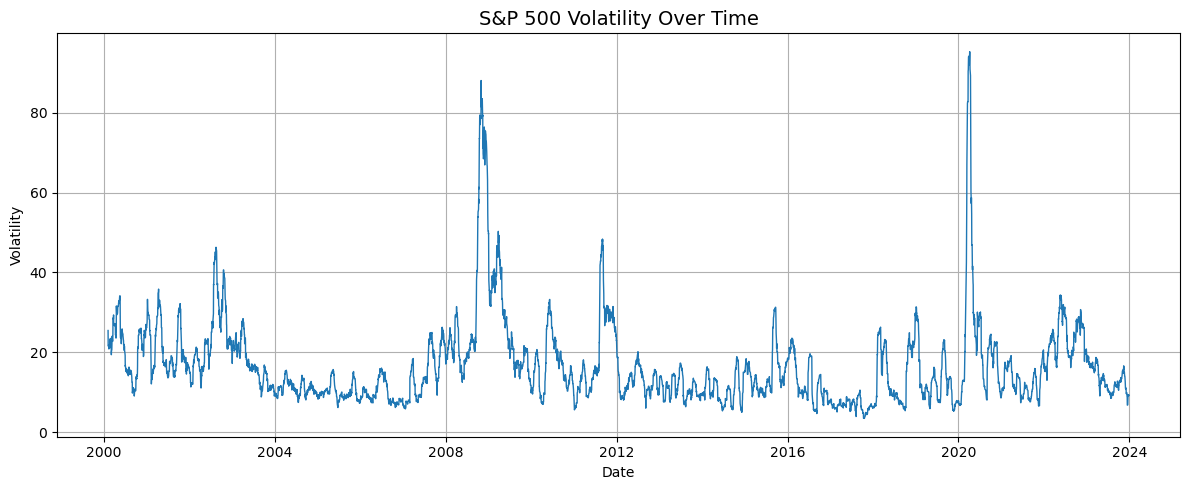

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(volatility*math.sqrt(252), linewidth=1)
plt.title('S&P 500 Volatility Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

## daily volatility = annual vol / sqrt(252)
# because there are 252 bussiness days in a year.

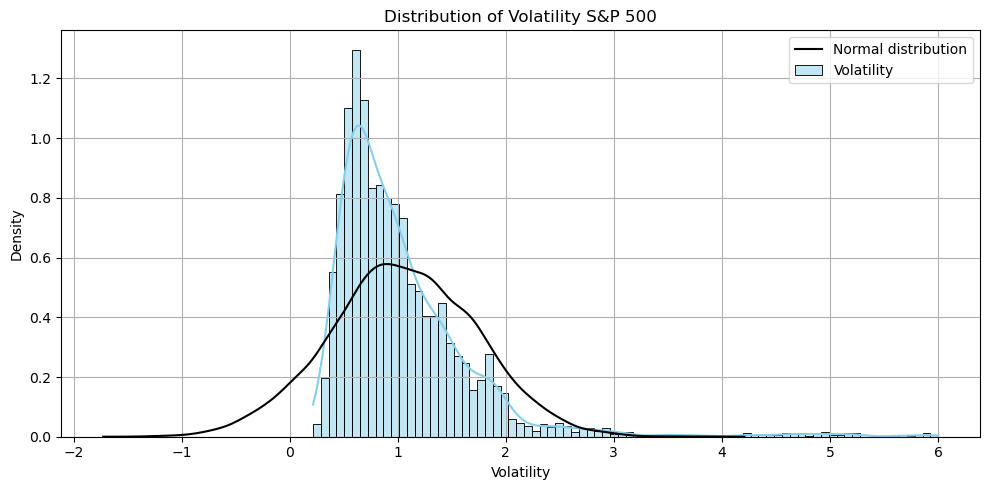

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(volatility, bins=80, kde=True, stat='density', color='skyblue', label='Volatility')
sns.kdeplot(np.random.normal(volatility.mean(), volatility.std(), size=10000),
            color='black', label='Normal distribution')
plt.title('Distribution of Volatility S&P 500')
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# VIX (2000 - 2025)

In [10]:
# --- Download VIX Data ---
ticker = '^VIX'
vix = yf.download(ticker, start= '2000-01-03', end= '2023-12-31', auto_adjust=True)
vix = vix['Close']

[*********************100%***********************]  1 of 1 completed


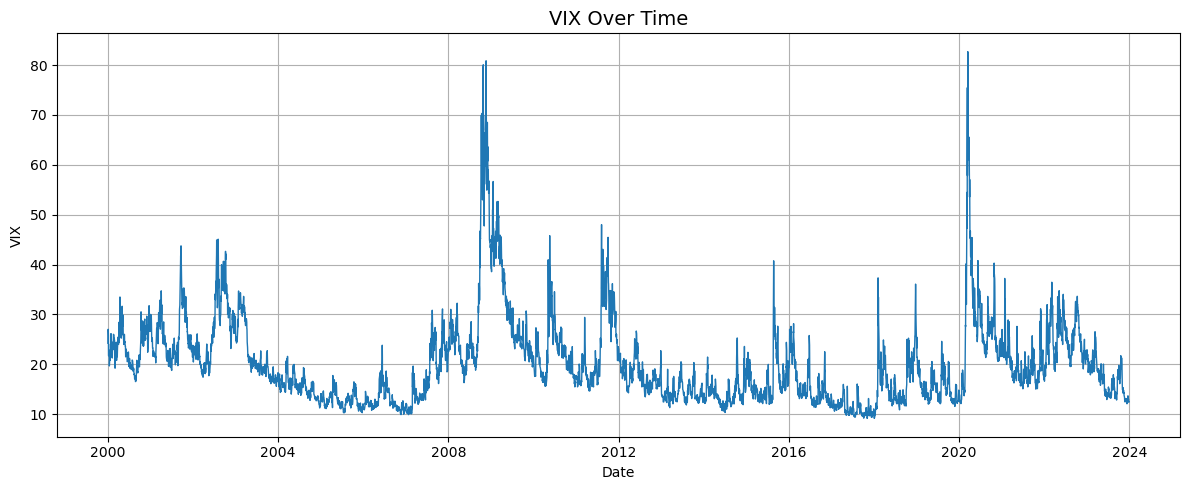

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(vix, linewidth=1)
plt.title('VIX Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('VIX')
plt.grid(True)
plt.tight_layout()
plt.show()

# annual volatility

/var/folders/cs/9h7p_scd025gkjlttrkq99100000gn/T/ipykernel_67493/1906705661.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.kdeplot(np.random.normal(vix.mean()[0], vix.std()[0], 10000),


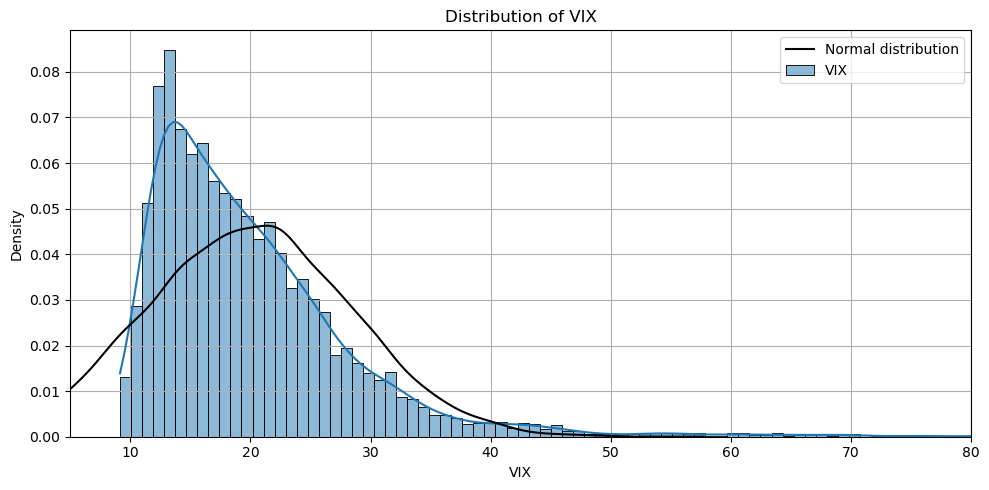

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(vix, bins=80, kde=True, stat='density', color='skyblue', label='VIX')
sns.kdeplot(np.random.normal(vix.mean()[0], vix.std()[0], 10000),
            color='black', label='Normal distribution')
plt.title('Distribution of VIX')
plt.xlabel('VIX')
plt.ylabel('Density')
plt.legend()
plt.xlim(5, 80)
plt.grid(True)
plt.tight_layout()
plt.show()

# FIT GARCH (p,q)

In [13]:
GARCH_P = 1 # GARCH lag for ARCH term
GARCH_Q = 1 # GARCH lag for GARCH term
DISTRIBUTION = 't' # Error distribution: 'normal', 't', 'skewt'
print(f"GARCH Model: GARCH({GARCH_P},{GARCH_Q}) with {DISTRIBUTION}-distribution")

GARCH Model: GARCH(1,1) with t-distribution


In [14]:
print(f"\nFitting GARCH({GARCH_P}, {GARCH_Q}) model with {DISTRIBUTION}-distribution...")

try:
    garch_model = arch_model(returns, vol='Garch', p=GARCH_P, q=GARCH_Q, dist=DISTRIBUTION)
    garch_results = garch_model.fit(update_freq=5, disp='off')
    print("GARCH Model Summary:")
    print(garch_results.summary())
    garch_conditional_std = garch_results.conditional_volatility
    print("GARCH conditional standard deviation extracted.")
except Exception as e:
    print(f"Error fitting GARCH model: {e}")
    print("This might happen if the data is not suitable or the model struggles to converge.")
    exit()


Fitting GARCH(1, 1) model with t-distribution...
GARCH Model Summary:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    LogReturn   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8230.39
Distribution:      Standardized Student's t   AIC:                           16470.8
Method:                  Maximum Likelihood   BIC:                           16504.3
                                              No. Observations:                 6036
Date:                      Thu, Jul 24 2025   Df Residuals:                     6035
Time:                              08:19:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------

## Rolling Forecast

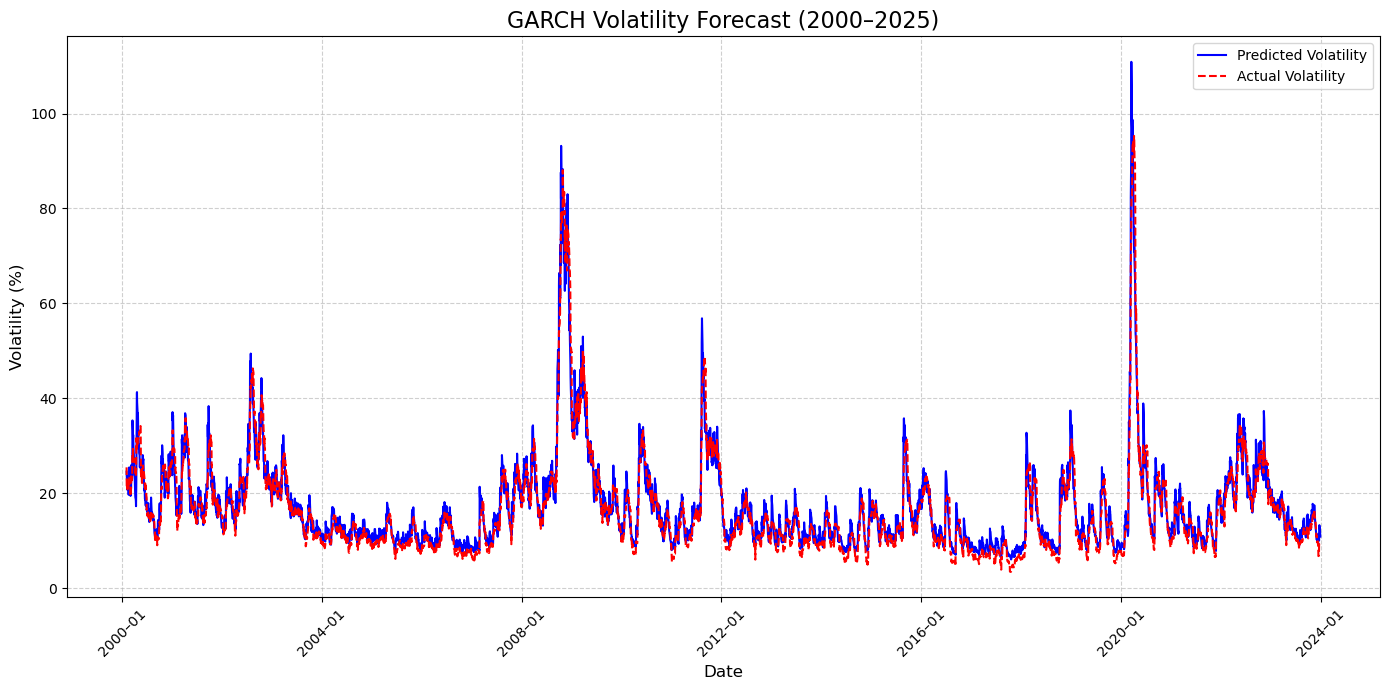

MAE: 1.2555e-01
RMSE: 1.7941e-01


In [15]:
# === Align the series for comparison ===
realized_variance_proxy = returns ** 2
common_index = volatility.index.intersection(garch_conditional_std.index).intersection(realized_variance_proxy.index)

volatility = volatility.loc[common_index]
garch_std_aligned = garch_conditional_std.loc[common_index]
realized_variance_proxy_aligned = realized_variance_proxy.loc[common_index]

# === Plot Rolling Std vs GARCH Conditional Std ===
fig2, ax2 = plt.subplots(figsize=(14, 7))
ax2.plot(garch_std_aligned.index, garch_std_aligned*math.sqrt(252), label="Predicted Volatility", color='blue')
ax2.plot(volatility*math.sqrt(252), label="Actual Volatility", color='red', linestyle='--')
ax2.set_title(f'GARCH Volatility Forecast (2000–2025)', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y–%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Error metrics ===
mae = mean_absolute_error(volatility, garch_std_aligned)
rmse = np.sqrt(mean_squared_error(volatility, garch_std_aligned))

print(f"MAE: {mae:.4e}")
print(f"RMSE: {rmse:.4e}")

# LSTM.    

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


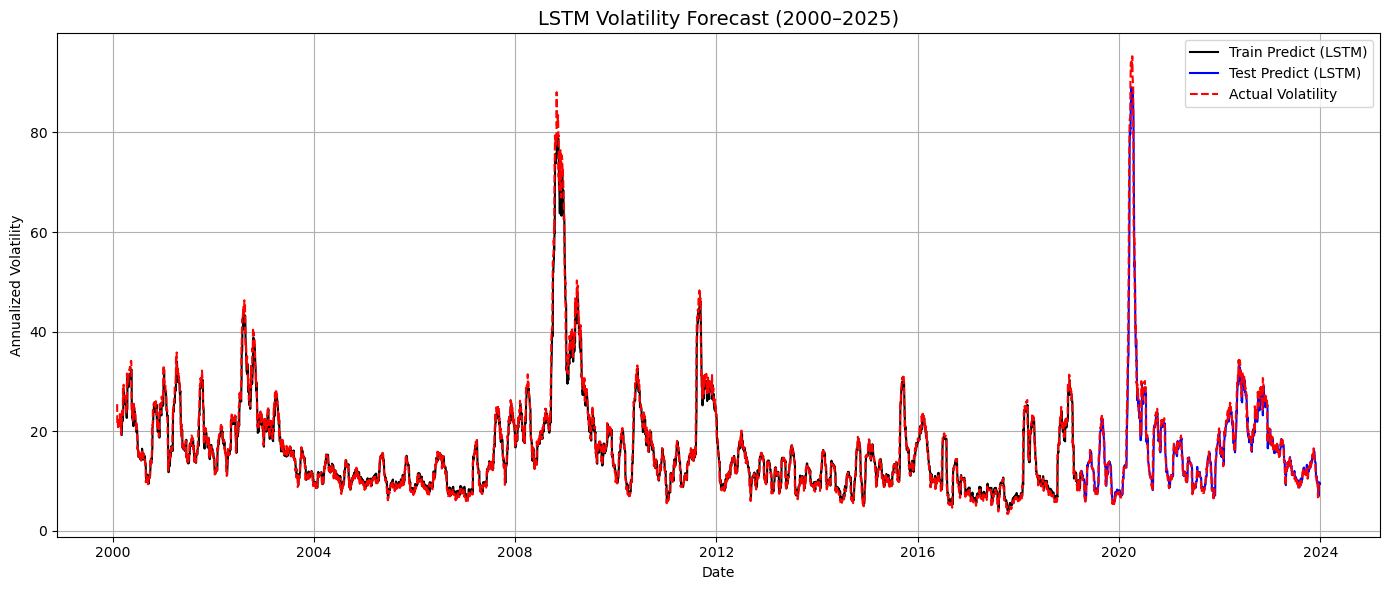

MAE (Test): 5.1748e-02
RMSE (Test): 9.4526e-02

MAE (Train): 4.7753e-02
RMSE (Train): 7.7095e-02


In [43]:
# === Step 1: Construct LSTM input ===
lstm_df = pd.concat([
    returns.rename("log_return"),
    volatility.shift(1).rename("lagged_vol"),
    volatility.rename("target_vol")
], axis=1).dropna()

# === Step 2: Normalize ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(lstm_df)

# === Step 3: Create dataset ===
look_back = 20
X, y = [], []
for i in range(len(scaled) - look_back - 1):
    X.append(scaled[i:i + look_back])
    y.append(scaled[i + look_back, 2])  # column 2 = target_vol
X = np.array(X)
y = np.array(y)

# === Step 4: Split ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === Step 5: Reshape ===
X_train = X_train.reshape((X_train.shape[0], look_back, X.shape[2]))
X_test = X_test.reshape((X_test.shape[0], look_back, X.shape[2]))


# === Step 6: Build the LSTM model with final hyperparameters ===
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# === Step 7: Train the model ===
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# === Step 8: Predict and inverse scale ===
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Recover inverse scaling for the target column
scaler_y = MinMaxScaler()
scaler_y.min_, scaler_y.scale_ = scaler.min_[2], scaler.scale_[2]  # target_vol column
train_pred_inv = scaler_y.inverse_transform(y_train_pred)
test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# === Step 9: Build Series for Plotting ===
full_index = lstm_df.index[look_back + 1:]
train_pred_series = pd.Series(train_pred_inv.flatten(), index=full_index[:split])
test_pred_series = pd.Series(test_pred_inv.flatten(), index=full_index[split:])

# === Step 9: Plot in Matching Style ===
plt.figure(figsize=(14, 6))
plt.plot(train_pred_series * math.sqrt(252), color='black', label='Train Predict (LSTM)')
plt.plot(test_pred_series * math.sqrt(252), color='blue', label='Test Predict (LSTM)')
plt.plot(volatility * math.sqrt(252), color='red', linestyle='--', label='Actual Volatility')
plt.title('LSTM Volatility Forecast (2000–2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Error Metrics ===
lstm_mae_2000_2025_test = mean_absolute_error(y_test_inv, test_pred_inv)
lstm_rmse_2000_2025_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"MAE (Test): {lstm_mae_2000_2025_test:.4e}")
print(f"RMSE (Test): {lstm_rmse_2000_2025_test:.4e}")
print()
lstm_mae_2000_2025_train = mean_absolute_error(y_train_inv, train_pred_inv)
lstm_rmse_2000_2025_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
print(f"MAE (Train): {lstm_mae_2000_2025_train:.4e}")
print(f"RMSE (Train): {lstm_rmse_2000_2025_train:.4e}")

# LSTM-GARCH.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


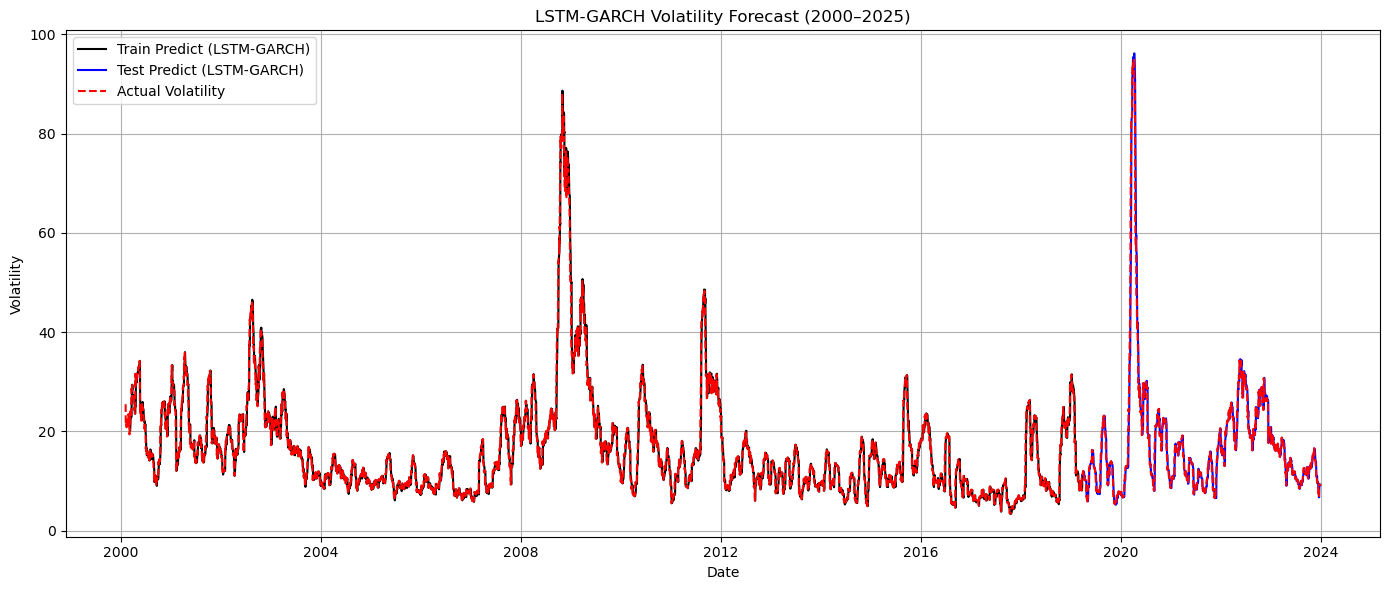

MAE (Test): 5.2484e-03
RMSE (Test): 1.1577e-02

MAE (Train): 4.6052e-03
RMSE (Train): 8.2732e-03


In [44]:
# === Step 1: Merge input data ===
# Assumes returns, volatility, predicted_vol already defined for 2000–2024
hybrid_df = pd.concat([
    returns.rename("log_return"),
    volatility.shift(1).rename("lagged_vol"),
    garch_std_aligned.rename("garch_forecast"),
    volatility.rename("target_vol")
], axis=1).dropna()

# === Step 2: Normalize data ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(hybrid_df)

# === Step 3: Create dataset ===
def create_dataset(data, look_back=20):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, 1])  # column 1 = lagged_vol (target_vol)
    return np.array(X), np.array(y)

look_back = 20
X, y = create_dataset(scaled, look_back)

# === Step 4: Split into train/test ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === Step 5: Reshape input ===
X_train = X_train.reshape(X_train.shape[0], look_back, X.shape[2])
X_test = X_test.reshape(X_test.shape[0], look_back, X.shape[2])

# === Step 6: Build the LSTM model with final hyperparameters ===
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# === Step 7: Train the model ===
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# === Step 7: Predict and inverse scale ===
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

scaler_y = MinMaxScaler()
scaler_y.min_, scaler_y.scale_ = scaler.min_[1], scaler.scale_[1]
train_pred_inv = scaler_y.inverse_transform(y_train_pred)
test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# === Step 8: Rebuild full timeline ===
full_index = hybrid_df.index[look_back + 1:]
train_pred_series = pd.Series(train_pred_inv.flatten(), index=full_index[:split])
test_pred_series = pd.Series(test_pred_inv.flatten(), index=full_index[split:])

# === Step 9: Plot — Train + Test Combined ===
plt.figure(figsize=(14, 6))
plt.plot(train_pred_series*math.sqrt(252), label='Train Predict (LSTM-GARCH)', color='black')
plt.plot(test_pred_series*math.sqrt(252), label='Test Predict (LSTM-GARCH)', color='blue')
plt.plot(volatility*math.sqrt(252), label='Actual Volatility', linestyle='--', color='red')
plt.title('LSTM-GARCH Volatility Forecast (2000–2025)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Error Metrics ===
lstm_garch_mae_2000_2025_test = mean_absolute_error(y_test_inv, test_pred_inv)
lstm_garch_rmse_2000_2025_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"MAE (Test): {lstm_garch_mae_2000_2025_test:.4e}")
print(f"RMSE (Test): {lstm_garch_rmse_2000_2025_test:.4e}")
print()
lstm_garch_mae_2000_2025_train = mean_absolute_error(y_train_inv, train_pred_inv)
lstm_garch_rmse_2000_2025_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
print(f"MAE (Train): {lstm_garch_mae_2000_2025_train:.4e}")
print(f"RMSE (Train): {lstm_garch_rmse_2000_2025_train:.4e}")

# LSTM-GARCH with the input VIX.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


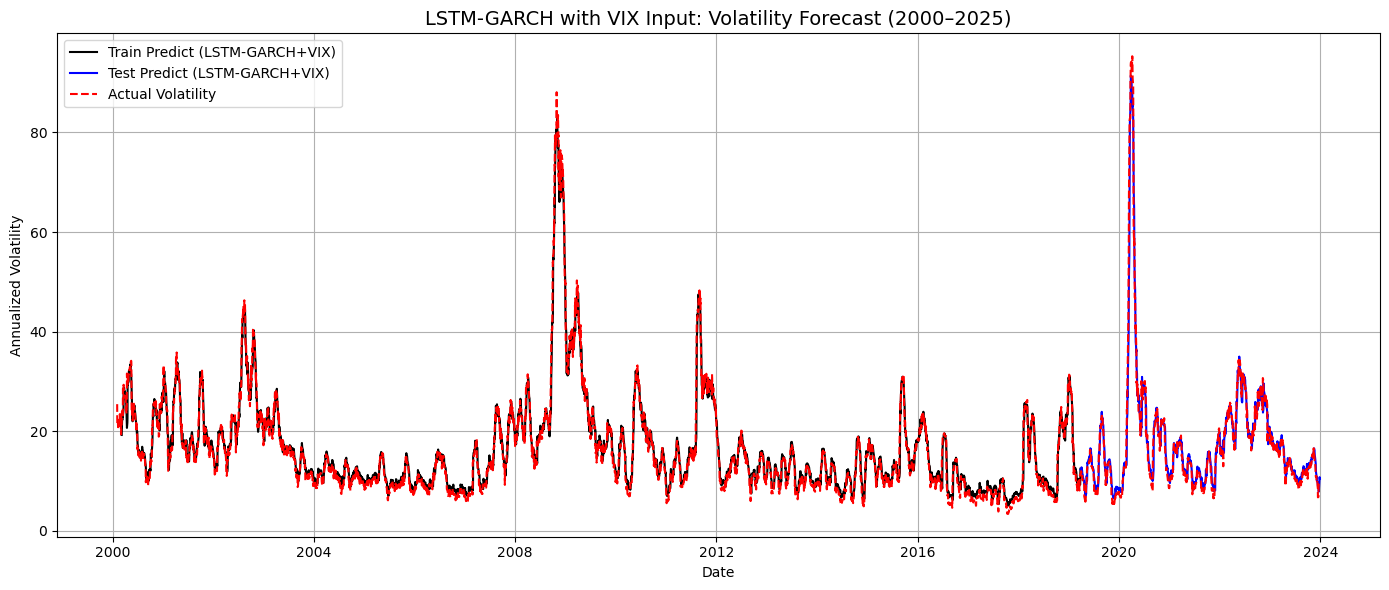

MAE (Test): 6.7468e-02
RMSE (Test): 1.0316e-01

MAE (Train): 8.8079e-01
RMSE (Train): 1.0339e+00


In [45]:
# === Step 1: Merge input data (include VIX) ===
# Assumes returns, volatility, predicted_vol, vix already defined
hybrid_df = pd.concat([
    returns.rename("log_return"),
    volatility.shift(1).rename("lagged_vol"),
    garch_std_aligned.rename("garch_forecast"),
    vix['^VIX'].rename("vix"),
    volatility.rename("target_vol")
], axis=1).dropna()

# === Step 2: Normalize data ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(hybrid_df)

# === Step 3: Create dataset ===
def create_dataset(data, look_back=20):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back, :-1])   # all input features except target
        y.append(data[i + look_back, -1])      # target_vol is the last column
    return np.array(X), np.array(y)

look_back = 20
X, y = create_dataset(scaled, look_back)

# === Step 4: Split into train/test ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === Step 6: Build the LSTM model with final hyperparameters ===
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# === Step 7: Train the model ===
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# === Step 6: Predict and inverse scale ===
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# === Step 7: Inverse scale predictions ===
scaler_y = MinMaxScaler()
scaler_y.min_, scaler_y.scale_ = scaler.min_[-1], scaler.scale_[-1]
train_pred_inv = scaler_y.inverse_transform(y_train_pred)
test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# === Step 8: Rebuild full timeline ===
full_index = hybrid_df.index[look_back + 1:]
train_pred_series = pd.Series(train_pred_inv.flatten(), index=full_index[:split])
test_pred_series = pd.Series(test_pred_inv.flatten(), index=full_index[split:])

# === Step 9: Plot — Train + Test Combined ===
plt.figure(figsize=(14, 6))
plt.plot(train_pred_series * math.sqrt(252), label='Train Predict (LSTM-GARCH+VIX)', color='black')
plt.plot(test_pred_series * math.sqrt(252), label='Test Predict (LSTM-GARCH+VIX)', color='blue')
plt.plot(volatility * math.sqrt(252), label='Actual Volatility', linestyle='--', color='red')
plt.title('LSTM-GARCH with VIX Input: Volatility Forecast (2000–2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_garch_vix_mae_2000_2025_test = mean_absolute_error(y_test_inv, test_pred_inv)
lstm_garch_vix_rmse_2000_2025_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"MAE (Test): {lstm_garch_vix_mae_2000_2025_test:.4e}")
print(f"RMSE (Test): {lstm_garch_vix_rmse_2000_2025_test:.4e}")
print()
lstm_garch_vix_mae_2000_2012_train = mean_absolute_error(y_train_inv, y_train_pred)
lstm_garch_vix_rmse_2000_2012_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred))
print(f"MAE (Train): {lstm_garch_vix_mae_2000_2012_train:.4e}")
print(f"RMSE (Train): {lstm_garch_vix_rmse_2000_2012_train:.4e}")

# S&P 500 and VIX (2000 - 2012)

In [46]:
start_2 = '2000-01-03'
end_2 = '2012-12-31'

In [47]:
# Download S&P 500 data
spy1 = yf.download('^GSPC', start= start_2, end= end_2, auto_adjust=True)
spy1['LogReturn'] = np.log(spy1['Close'] / spy1['Close'].shift(1))
spy1.dropna(inplace=True)
returns_1 = spy1['LogReturn'] * 100  # % returns

# Rolling 22-day volatility (not annualized)
volatility_1 = returns_1.rolling(window=22).std().dropna()

# Download VIX data
vix1 = yf.download('^VIX', start= start_2, end= end_2, auto_adjust=True)
vix1 = vix1['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


GARCH

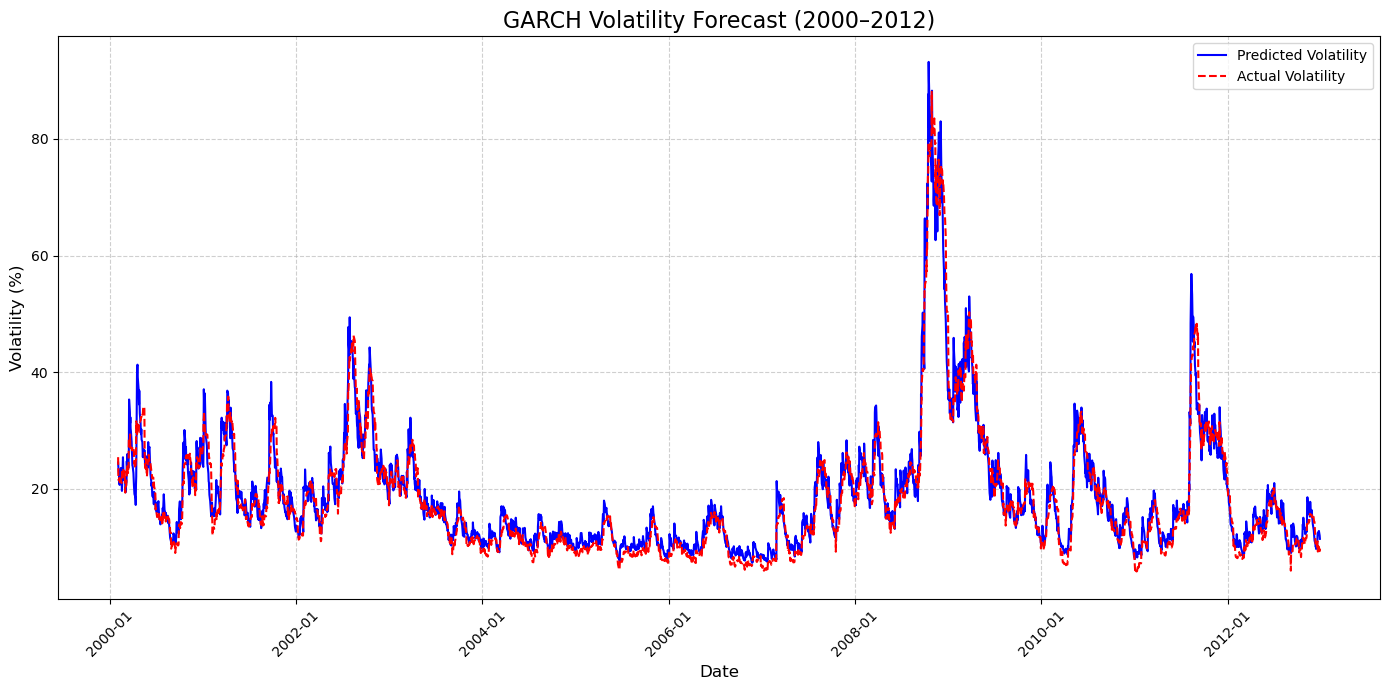

MAE (2000–2012): 1.2488e-01
RMSE (2000–2012): 1.7646e-01


In [48]:
# === Align the series for comparison (2000–2012) ===
realized_variance_proxy_1 = returns_1 ** 2  # using returns_1 from 2000–2012
common_index_1 = volatility_1.index.intersection(garch_conditional_std.index).intersection(realized_variance_proxy_1.index)

volatility_1 = volatility_1.loc[common_index_1]
garch_std_aligned_1 = garch_conditional_std.loc[common_index_1]
realized_variance_proxy_aligned_1 = realized_variance_proxy_1.loc[common_index_1]

# === Plot Rolling Std vs GARCH Conditional Std (2000–2012) ===
fig2, ax2 = plt.subplots(figsize=(14, 7))
ax2.plot(garch_std_aligned_1.index, garch_std_aligned_1*math.sqrt(252), label="Predicted Volatility", color='blue')
ax2.plot(volatility_1*math.sqrt(252), label="Actual Volatility", color='red', linestyle='--')

ax2.set_title('GARCH Volatility Forecast (2000–2012)', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Error metrics ===
mae_1 = mean_absolute_error(volatility_1, garch_std_aligned_1)
rmse_1 = np.sqrt(mean_squared_error(volatility_1, garch_std_aligned_1))

print(f"MAE (2000–2012): {mae_1:.4e}")
print(f"RMSE (2000–2012): {rmse_1:.4e}")

LSTM.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


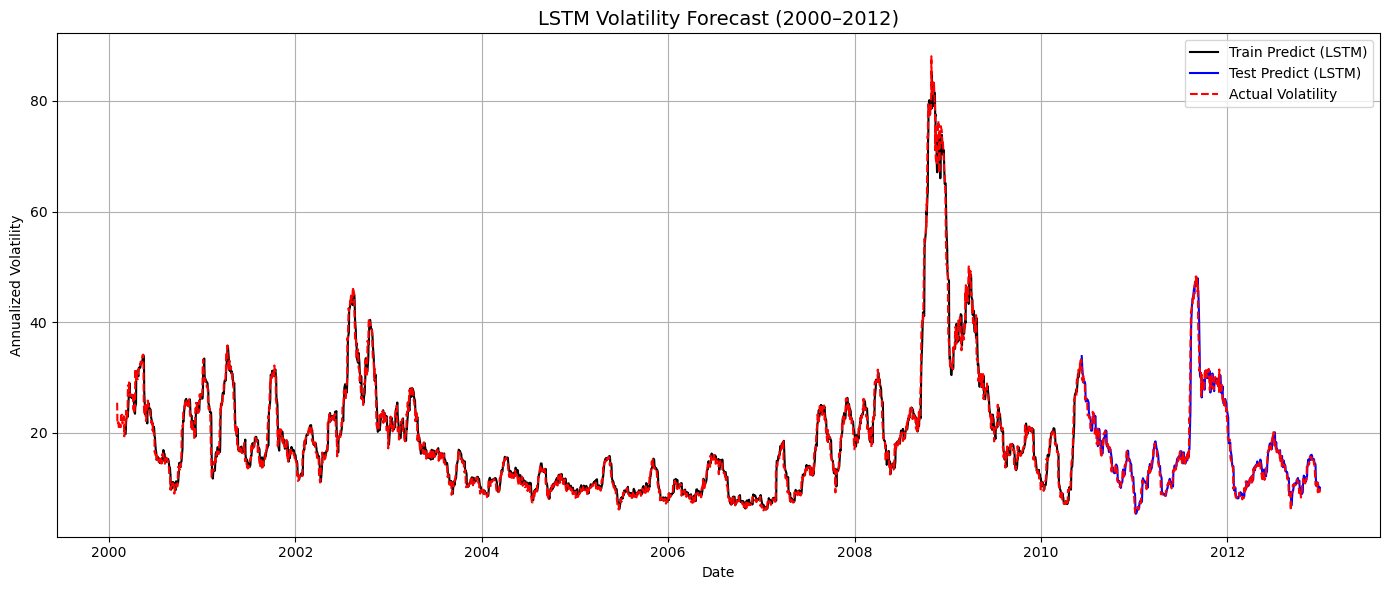

LSTM MAE (Test): 4.0704e-02
LSTM RMSE (Test): 6.3110e-02
LSTM MAE (Train): 4.3914e-02
LSTM RMSE (Train): 7.1334e-02


In [49]:
# LSTM pure model — Sample 2 (2000–2012)
lstm_df_1 = pd.concat([
    returns_1.rename("log_return"),
    volatility_1.shift(1).rename("lagged_vol"),
    volatility_1.rename("target_vol")
], axis=1).dropna()

# === Step 2: Normalize ===
scaler_1 = MinMaxScaler()
scaled_1 = scaler_1.fit_transform(lstm_df_1)

# === Step 3: Create dataset ===
look_back = 20
X_1, y_1 = [], []
for i in range(len(scaled_1) - look_back - 1):
    X_1.append(scaled_1[i:i + look_back])
    y_1.append(scaled_1[i + look_back, 2])  # column 2 = target_vol
X_1 = np.array(X_1)
y_1 = np.array(y_1)

# === Step 4: Split ===
split_1 = int(len(X_1) * 0.8)
X_train_1, X_test_1 = X_1[:split_1], X_1[split_1:]
y_train_1, y_test_1 = y_1[:split_1], y_1[split_1:]

# === Step 5: Reshape ===
X_train_1 = X_train_1.reshape((X_train_1.shape[0], look_back, X_1.shape[2]))
X_test_1 = X_test_1.reshape((X_test_1.shape[0], look_back, X_1.shape[2]))

# === Step 6: Build and Train Updated LSTM ===
model_1 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X_1.shape[2])),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_1.fit(X_train_1, y_train_1, epochs=100, batch_size=64, verbose=0)

# === Step 7: Predict & Inverse Scale ===
y_train_pred_1 = model_1.predict(X_train_1)
y_test_pred_1 = model_1.predict(X_test_1)

scaler_y_1 = MinMaxScaler()
scaler_y_1.min_, scaler_y_1.scale_ = scaler_1.min_[2], scaler_1.scale_[2]  # target_vol column
train_pred_inv_1 = scaler_y_1.inverse_transform(y_train_pred_1)
test_pred_inv_1 = scaler_y_1.inverse_transform(y_test_pred_1)
y_train_inv_1 = scaler_y_1.inverse_transform(y_train_1.reshape(-1, 1))
y_test_inv_1 = scaler_y_1.inverse_transform(y_test_1.reshape(-1, 1))

# === Step 8: Build Series for Plotting ===
full_index_1 = lstm_df_1.index[look_back + 1:]
train_pred_series_1 = pd.Series(train_pred_inv_1.flatten(), index=full_index_1[:split_1])
test_pred_series_1 = pd.Series(test_pred_inv_1.flatten(), index=full_index_1[split_1:])

# === Step 9: Plot in Matching Style ===
plt.figure(figsize=(14, 6))
plt.plot(train_pred_series_1 * math.sqrt(252), color='black', label='Train Predict (LSTM)')
plt.plot(test_pred_series_1 * math.sqrt(252), color='blue', label='Test Predict (LSTM)')
plt.plot(volatility_1 * math.sqrt(252), color='red', linestyle='--', label='Actual Volatility')
plt.title('LSTM Volatility Forecast (2000–2012)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_mae_2000_2012_test = mean_absolute_error(y_test_inv_1, test_pred_inv_1)
lstm_rmse_2000_2012_test = np.sqrt(mean_squared_error(y_test_inv_1, test_pred_inv_1))
lstm_mae_2000_2012_train = mean_absolute_error(y_train_inv_1, train_pred_inv_1)
lstm_rmse_2000_2012_train = np.sqrt(mean_squared_error(y_train_inv_1, train_pred_inv_1))
print(f"LSTM MAE (Test): {lstm_mae_2000_2012_test:.4e}")
print(f"LSTM RMSE (Test): {lstm_rmse_2000_2012_test:.4e}")
print(f"LSTM MAE (Train): {lstm_mae_2000_2012_train:.4e}")
print(f"LSTM RMSE (Train): {lstm_rmse_2000_2012_train:.4e}")

LSTM+GARCH.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


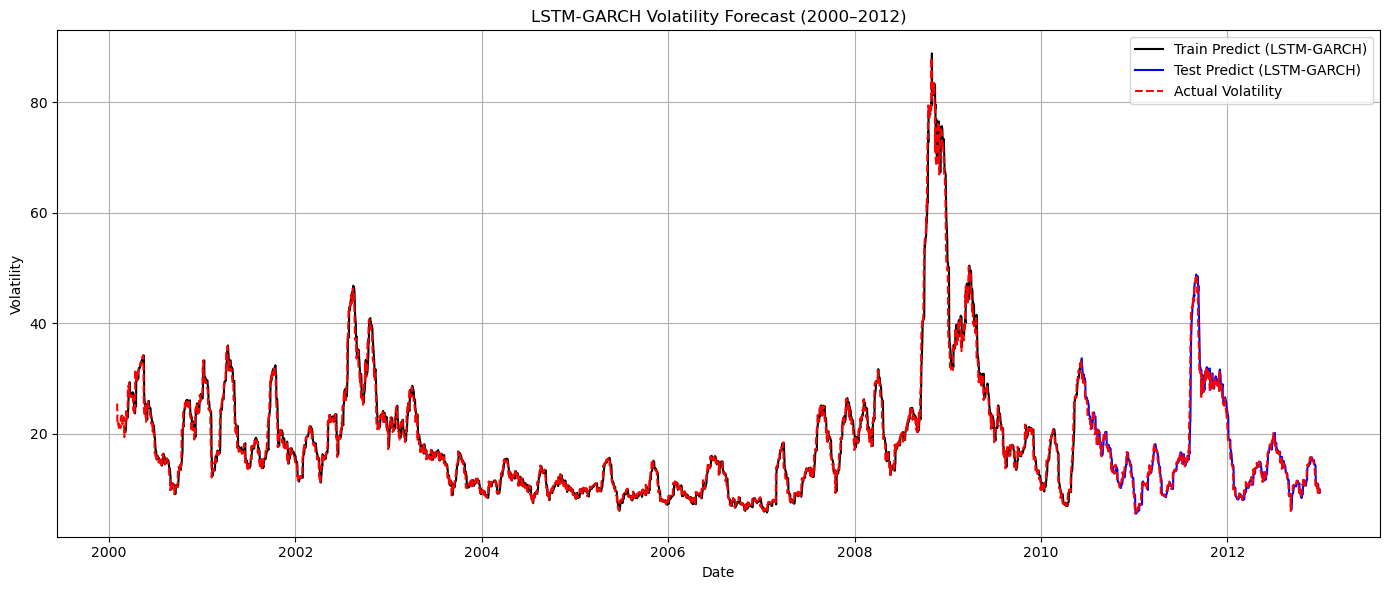

LSTM-GARCH MAE (Test): 8.3736e-03
LSTM-GARCH RMSE (Test): 1.2000e-02
LSTM-GARCH MAE (Train): 1.0236e-02
LSTM-GARCH RMSE (Train): 1.4305e-02


In [50]:
# LSTM-GARCH hybrid model — Sample 2 (2000–2012)
hybrid_df_1 = pd.concat([
    returns_1.rename("log_return"),
    volatility_1.shift(1).rename("lagged_vol"),
    garch_std_aligned_1.rename("garch_forecast"),
    volatility_1.rename("target_vol")
], axis=1).dropna()

# === Step 2: Normalize data ===
scaler_1 = MinMaxScaler()
scaled_1 = scaler_1.fit_transform(hybrid_df_1)

def create_dataset_1(data, look_back=20):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, 1])  # lagged_vol is target
    return np.array(X), np.array(y)

X_1, y_1 = create_dataset_1(scaled_1, look_back)

split_1 = int(len(X_1) * 0.8)
X_train_1, X_test_1 = X_1[:split_1], X_1[split_1:]
y_train_1, y_test_1 = y_1[:split_1], y_1[split_1:]

X_train_1 = X_train_1.reshape(X_train_1.shape[0], look_back, X_1.shape[2])
X_test_1 = X_test_1.reshape(X_test_1.shape[0], look_back, X_1.shape[2])

# === Step 6: Build and Train Updated LSTM ===
model_1 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X_1.shape[2])),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_1.fit(X_train_1, y_train_1, epochs=100, batch_size=64, verbose=0)

y_train_pred_1 = model_1.predict(X_train_1)
y_test_pred_1 = model_1.predict(X_test_1)

scaler_y_1 = MinMaxScaler()
scaler_y_1.min_, scaler_y_1.scale_ = scaler_1.min_[1], scaler_1.scale_[1]  # lagged_vol
train_pred_inv_1 = scaler_y_1.inverse_transform(y_train_pred_1)
test_pred_inv_1 = scaler_y_1.inverse_transform(y_test_pred_1)
y_train_inv_1 = scaler_y_1.inverse_transform(y_train_1.reshape(-1, 1))
y_test_inv_1 = scaler_y_1.inverse_transform(y_test_1.reshape(-1, 1))

full_index_1 = hybrid_df_1.index[look_back + 1:]
train_pred_series_1 = pd.Series(train_pred_inv_1.flatten(), index=full_index_1[:split_1])
test_pred_series_1 = pd.Series(test_pred_inv_1.flatten(), index=full_index_1[split_1:])

plt.figure(figsize=(14, 6))
plt.plot(train_pred_series_1 * math.sqrt(252), label='Train Predict (LSTM-GARCH)', color='black')
plt.plot(test_pred_series_1 * math.sqrt(252), label='Test Predict (LSTM-GARCH)', color='blue')
plt.plot(volatility_1 * math.sqrt(252), label='Actual Volatility', linestyle='--', color='red')
plt.title('LSTM-GARCH Volatility Forecast (2000–2012)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_garch_mae_2000_2012_test = mean_absolute_error(y_test_inv_1, test_pred_inv_1)
lstm_garch_rmse_2000_2012_test = np.sqrt(mean_squared_error(y_test_inv_1, test_pred_inv_1))
lstm_garch_mae_2000_2012_train = mean_absolute_error(y_train_inv_1, train_pred_inv_1)
lstm_garch_rmse_2000_2012_train = np.sqrt(mean_squared_error(y_train_inv_1, train_pred_inv_1))
print(f"LSTM-GARCH MAE (Test): {lstm_garch_mae_2000_2012_test:.4e}")
print(f"LSTM-GARCH RMSE (Test): {lstm_garch_rmse_2000_2012_test:.4e}")
print(f"LSTM-GARCH MAE (Train): {lstm_garch_mae_2000_2012_train:.4e}")
print(f"LSTM-GARCH RMSE (Train): {lstm_garch_rmse_2000_2012_train:.4e}")

LSTM-GARCH+VIX.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


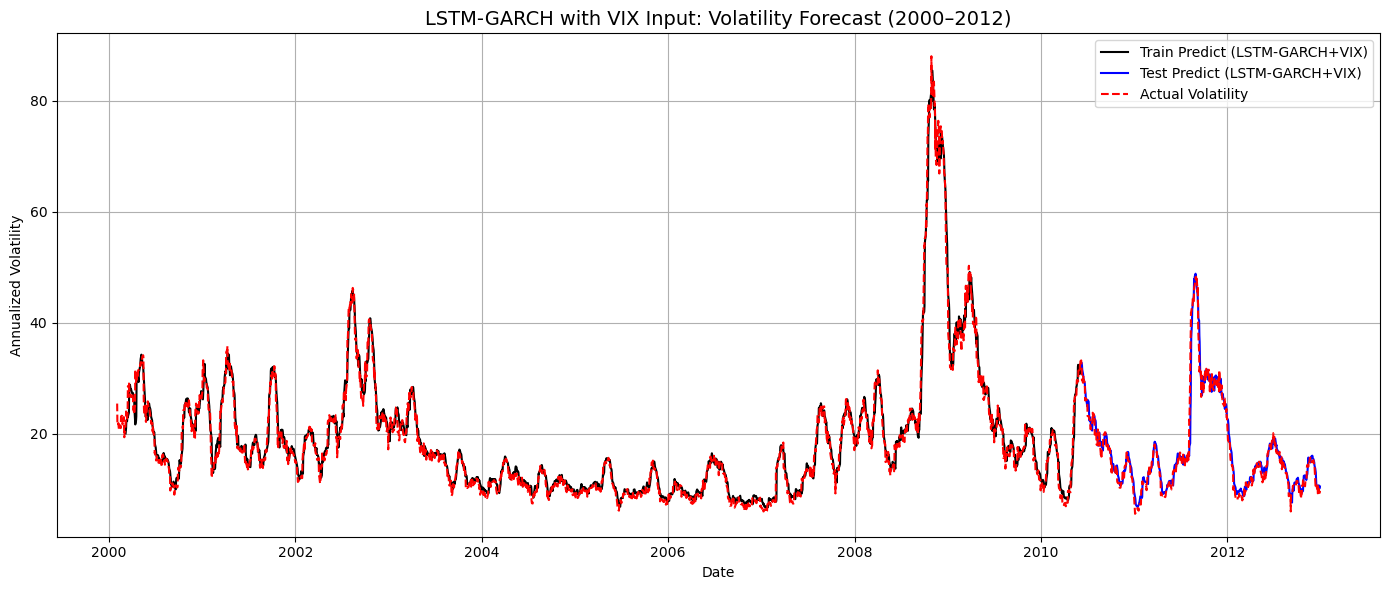

LSTM-GARCH+VIX MAE (Test): 5.4086e-02
LSTM-GARCH+VIX RMSE (Test): 7.5489e-02
LSTM-GARCH+VIX MAE (Train): 5.9385e-02
LSTM-GARCH+VIX RMSE (Train): 8.3769e-02


In [51]:
# LSTM-GARCH+VIX hybrid model — Sample 2 (2000–2012)
hybrid_df_1 = pd.concat([
    returns_1.rename("log_return"),
    volatility_1.shift(1).rename("lagged_vol"),
    garch_std_aligned_1.rename("garch_forecast"),
    vix1['^VIX'].rename("vix"), # Use raw VIX closing prices
    volatility_1.rename("target_vol")
], axis=1).dropna()

# === Step 2: Normalize data ===
scaler_1 = MinMaxScaler()
scaled_1 = scaler_1.fit_transform(hybrid_df_1)

def create_dataset_1(data, look_back=20):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back, :-1])
        y.append(data[i + look_back, -1])
    return np.array(X), np.array(y)

X_1, y_1 = create_dataset_1(scaled_1, look_back)

split_1 = int(len(X_1) * 0.8)
X_train_1, X_test_1 = X_1[:split_1], X_1[split_1:]
y_train_1, y_test_1 = y_1[:split_1], y_1[split_1:]

# === Step 6: Build and Train Updated LSTM ===
model_1 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X_1.shape[2])),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_1.fit(X_train_1, y_train_1, epochs=100, batch_size=64, verbose=0)

y_train_pred_1 = model_1.predict(X_train_1)
y_test_pred_1 = model_1.predict(X_test_1)

scaler_y_1 = MinMaxScaler()
scaler_y_1.min_, scaler_y_1.scale_ = scaler_1.min_[-1], scaler_1.scale_[-1]
train_pred_inv_1 = scaler_y_1.inverse_transform(y_train_pred_1)
test_pred_inv_1 = scaler_y_1.inverse_transform(y_test_pred_1)
y_train_inv_1 = scaler_y_1.inverse_transform(y_train_1.reshape(-1, 1))
y_test_inv_1 = scaler_y_1.inverse_transform(y_test_1.reshape(-1, 1))

full_index_1 = hybrid_df_1.index[look_back + 1:]
train_pred_series_1 = pd.Series(train_pred_inv_1.flatten(), index=full_index_1[:split_1])
test_pred_series_1 = pd.Series(test_pred_inv_1.flatten(), index=full_index_1[split_1:])

plt.figure(figsize=(14, 6))
plt.plot(train_pred_series_1 * math.sqrt(252), label='Train Predict (LSTM-GARCH+VIX)', color='black')
plt.plot(test_pred_series_1 * math.sqrt(252), label='Test Predict (LSTM-GARCH+VIX)', color='blue')
plt.plot(volatility_1 * math.sqrt(252), label='Actual Volatility', linestyle='--', color='red')
plt.title('LSTM-GARCH with VIX Input: Volatility Forecast (2000–2012)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_garch_vix_mae_2000_2012_test = mean_absolute_error(y_test_inv_1, test_pred_inv_1)
lstm_garch_vix_rmse_2000_2012_test = np.sqrt(mean_squared_error(y_test_inv_1, test_pred_inv_1))
lstm_garch_vix_mae_2000_2012_train = mean_absolute_error(y_train_inv_1, train_pred_inv_1)
lstm_garch_vix_rmse_2000_2012_train = np.sqrt(mean_squared_error(y_train_inv_1, train_pred_inv_1))
print(f"LSTM-GARCH+VIX MAE (Test): {lstm_garch_vix_mae_2000_2012_test:.4e}")
print(f"LSTM-GARCH+VIX RMSE (Test): {lstm_garch_vix_rmse_2000_2012_test:.4e}")
print(f"LSTM-GARCH+VIX MAE (Train): {lstm_garch_vix_mae_2000_2012_train:.4e}")
print(f"LSTM-GARCH+VIX RMSE (Train): {lstm_garch_vix_rmse_2000_2012_train:.4e}")

# 2013-2025

In [52]:
start_3 = '2013-01-01'
end_3 = '2024-12-31'

In [53]:
# Download S&P 500 data
spy2 = yf.download('^GSPC', start= start_3, end= end_3, auto_adjust=True)
spy2['LogReturn'] = np.log(spy2['Close'] / spy2['Close'].shift(1))
spy2.dropna(inplace=True)
returns_2 = spy2['LogReturn'] * 100  # % returns

# Rolling 22-day volatility (not annualized)
volatility_2 = returns_2.rolling(window=22).std().dropna()

# Download VIX data
vix_2 = yf.download('^VIX', start= start_3, end= end_3, auto_adjust=True)
vix_2 = vix_2['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


GARCH.

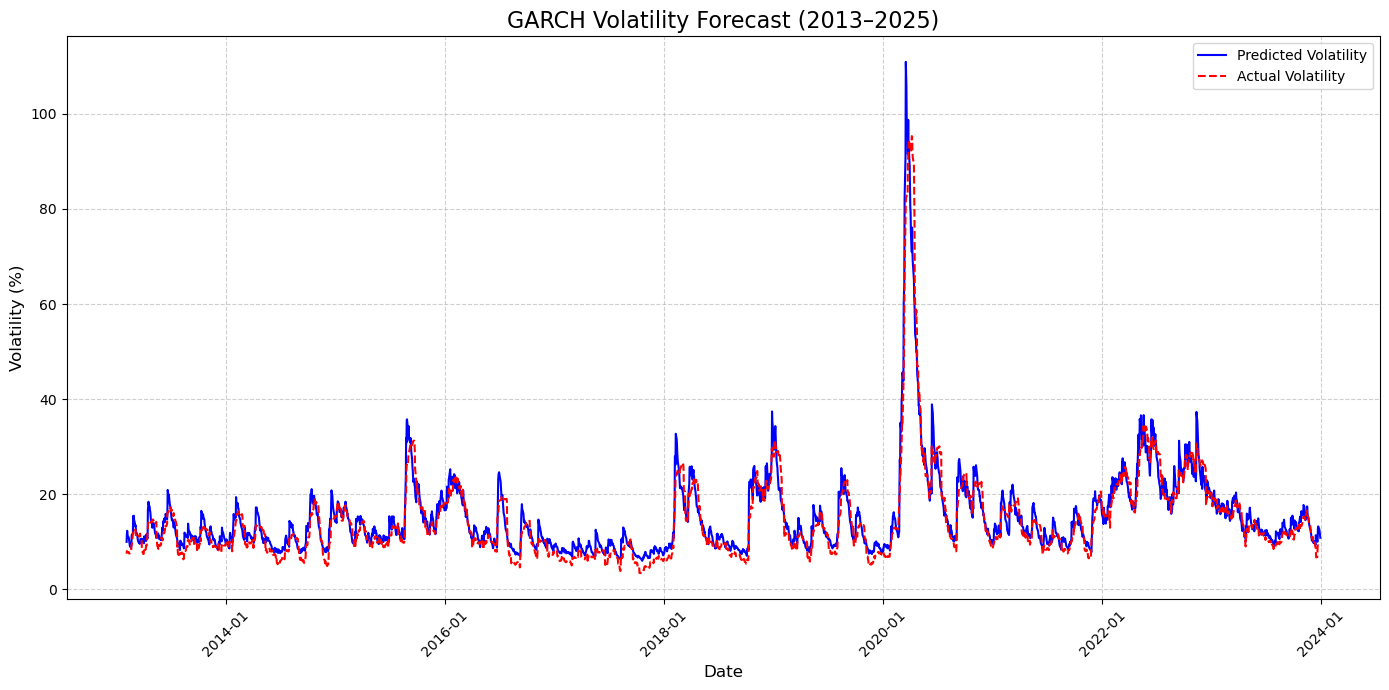

MAE (2013–2025): 1.2633e-01
RMSE (2013–2025): 1.8308e-01


In [54]:
# === Align the series for comparison (2013–2025) ===
realized_variance_proxy_2 = returns_2 ** 2  # using returns_2 from 2013–2025
# Ensure garch_conditional_std_2 is defined or use the one from the first sample if applicable
# Assuming garch_conditional_std is for the full 2000-2025 period and can be used for alignment
common_index_2 = volatility_2.index.intersection(garch_conditional_std.index).intersection(realized_variance_proxy_2.index)


volatility_2 = volatility_2.loc[common_index_2]
# Assuming garch_conditional_std is for the full period and we are aligning a portion
garch_std_aligned_2 = garch_conditional_std.loc[common_index_2]
realized_variance_proxy_aligned_2 = realized_variance_proxy_2.loc[common_index_2]

# === Plot Rolling Std vs GARCH Conditional Std (2013–2025) ===
fig2, ax2 = plt.subplots(figsize=(14, 7))
ax2.plot(garch_std_aligned_2.index, garch_std_aligned_2*math.sqrt(252), label="Predicted Volatility", color='blue')
ax2.plot(volatility_2*math.sqrt(252), label="Actual Volatility", color='red', linestyle='--')

ax2.set_title('GARCH Volatility Forecast (2013–2025)', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Volatility (%)', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Error metrics ===
mae_2 = mean_absolute_error(volatility_2, garch_std_aligned_2)
rmse_2 = np.sqrt(mean_squared_error(volatility_2, garch_std_aligned_2))

print(f"MAE (2013–2025): {mae_2:.4e}")
print(f"RMSE (2013–2025): {rmse_2:.4e}")

LSTM.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


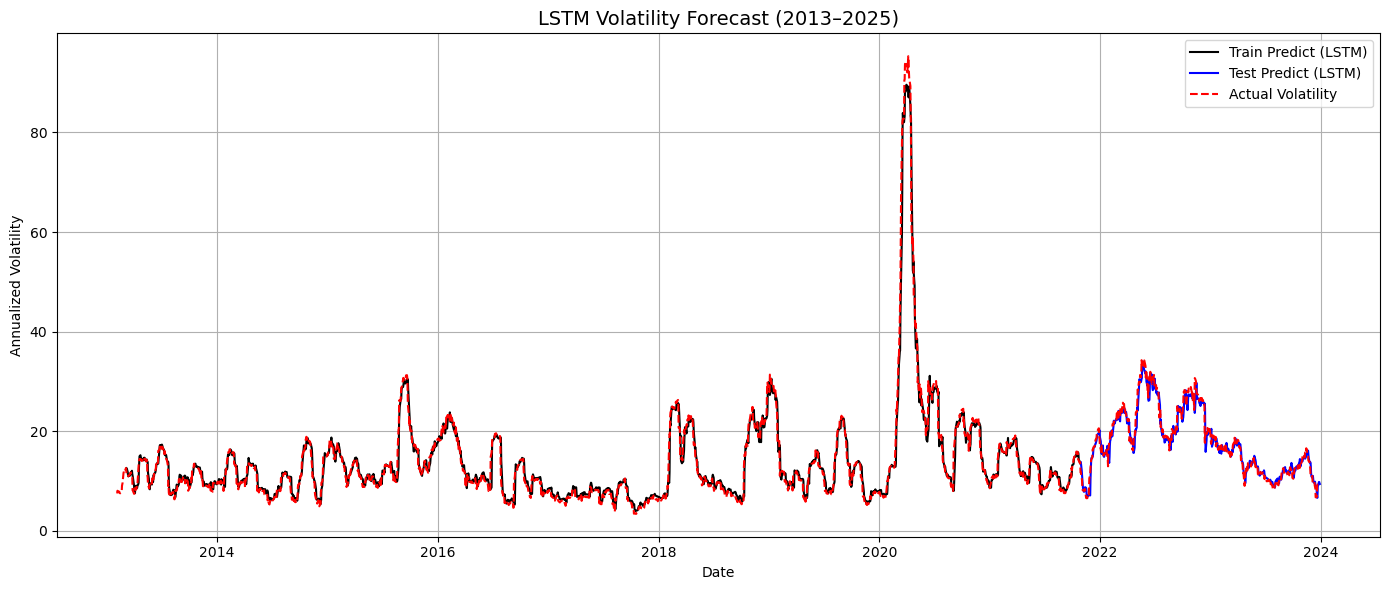

LSTM MAE (Test): 4.8061e-02
LSTM RMSE (Test): 6.7366e-02
LSTM MAE (Train): 4.3144e-02
LSTM RMSE (Train): 7.1854e-02


In [55]:
# LSTM pure model — Sample 3 (2013–2025)
lstm_df_2 = pd.concat([
    returns_2.rename("log_return"),
    volatility_2.shift(1).rename("lagged_vol"),
    volatility_2.rename("target_vol")
], axis=1).dropna()

scaler_2 = MinMaxScaler()
scaled_2 = scaler_2.fit_transform(lstm_df_2)

look_back = 20
X_2, y_2 = [], []
for i in range(len(scaled_2) - look_back - 1):
    X_2.append(scaled_2[i:i + look_back])
    y_2.append(scaled_2[i + look_back, 2])
X_2 = np.array(X_2)
y_2 = np.array(y_2)

split_2 = int(len(X_2) * 0.8)
X_train_2, X_test_2 = X_2[:split_2], X_2[split_2:]
y_train_2, y_test_2 = y_2[:split_2], y_2[split_2:]

X_train_2 = X_train_2.reshape((X_train_2.shape[0], look_back, X_2.shape[2]))
X_test_2 = X_test_2.reshape((X_test_2.shape[0], look_back, X_2.shape[2]))

model_2 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X_2.shape[2])),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_2.fit(X_train_2, y_train_2, epochs=100, batch_size=64, verbose=0)

y_train_pred_2 = model_2.predict(X_train_2)
y_test_pred_2 = model_2.predict(X_test_2)

scaler_y_2 = MinMaxScaler()
scaler_y_2.min_, scaler_y_2.scale_ = scaler_2.min_[2], scaler_2.scale_[2]
train_pred_inv_2 = scaler_y_2.inverse_transform(y_train_pred_2)
test_pred_inv_2 = scaler_y_2.inverse_transform(y_test_pred_2)
y_train_inv_2 = scaler_y_2.inverse_transform(y_train_2.reshape(-1, 1))
y_test_inv_2 = scaler_y_2.inverse_transform(y_test_2.reshape(-1, 1))

full_index_2 = lstm_df_2.index[look_back + 1:]
train_pred_series_2 = pd.Series(train_pred_inv_2.flatten(), index=full_index_2[:split_2])
test_pred_series_2 = pd.Series(test_pred_inv_2.flatten(), index=full_index_2[split_2:])


plt.figure(figsize=(14, 6))
plt.plot(train_pred_series_2 * math.sqrt(252), color='black', label='Train Predict (LSTM)')
plt.plot(test_pred_series_2 * math.sqrt(252), color='blue', label='Test Predict (LSTM)')
plt.plot(volatility_2 * math.sqrt(252), color='red', linestyle='--', label='Actual Volatility')
plt.title('LSTM Volatility Forecast (2013–2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_mae_2013_2025_test = mean_absolute_error(y_test_inv_2, test_pred_inv_2)
lstm_rmse_2013_2025_test = np.sqrt(mean_squared_error(y_test_inv_2, test_pred_inv_2))
lstm_mae_2013_2025_train = mean_absolute_error(y_train_inv_2, train_pred_inv_2)
lstm_rmse_2013_2025_train = np.sqrt(mean_squared_error(y_train_inv_2, train_pred_inv_2))
print(f"LSTM MAE (Test): {lstm_mae_2013_2025_test:.4e}")
print(f"LSTM RMSE (Test): {lstm_rmse_2013_2025_test:.4e}")
print(f"LSTM MAE (Train): {lstm_mae_2013_2025_train:.4e}")
print(f"LSTM RMSE (Train): {lstm_rmse_2013_2025_train:.4e}")

LSTM-GARCH.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


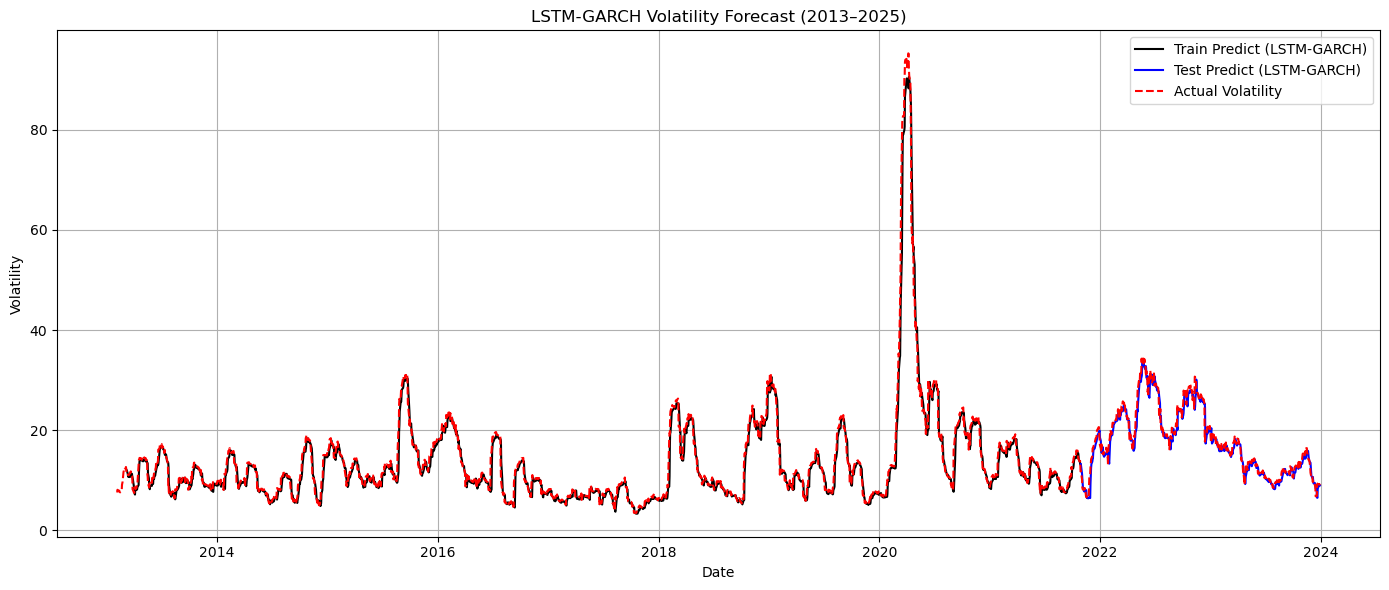

LSTM-GARCH MAE (Test): 2.7538e-02
LSTM-GARCH RMSE (Test): 3.2357e-02
LSTM-GARCH MAE (Train): 2.5959e-02
LSTM-GARCH RMSE (Train): 3.7111e-02


In [56]:
# LSTM-GARCH hybrid model — Sample 3 (2013–2025)
hybrid_df_2 = pd.concat([
    returns_2.rename("log_return"),
    volatility_2.shift(1).rename("lagged_vol"),
    garch_std_aligned_2.rename("garch_forecast"),
    volatility_2.rename("target_vol")
], axis=1).dropna()

scaler_2 = MinMaxScaler()
scaled_2 = scaler_2.fit_transform(hybrid_df_2)

def create_dataset_2(data, look_back=20):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, 1])  # lagged_vol is target
    return np.array(X), np.array(y)

X_2, y_2 = create_dataset_2(scaled_2, look_back)

split_2 = int(len(X_2) * 0.8)
X_train_2, X_test_2 = X_2[:split_2], X_2[split_2:]
y_train_2, y_test_2 = y_2[:split_2], y_2[split_2:]

X_train_2 = X_train_2.reshape(X_train_2.shape[0], look_back, X_2.shape[2])
X_test_2 = X_test_2.reshape(X_test_2.shape[0], look_back, X_2.shape[2])


model_2 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X_2.shape[2])),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_2.fit(X_train_2, y_train_2, epochs=100, batch_size=64, verbose=0)

y_train_pred_2 = model_2.predict(X_train_2)
y_test_pred_2 = model_2.predict(X_test_2)

scaler_y_2 = MinMaxScaler()
scaler_y_2.min_, scaler_y_2.scale_ = scaler_2.min_[1], scaler_2.scale_[1]
train_pred_inv_2 = scaler_y_2.inverse_transform(y_train_pred_2)
test_pred_inv_2 = scaler_y_2.inverse_transform(y_test_pred_2)
y_train_inv_2 = scaler_y_2.inverse_transform(y_train_2.reshape(-1, 1))
y_test_inv_2 = scaler_y_2.inverse_transform(y_test_2.reshape(-1, 1))

full_index_2 = hybrid_df_2.index[look_back + 1:]
train_pred_series_2 = pd.Series(train_pred_inv_2.flatten(), index=full_index_2[:split_2])
test_pred_series_2 = pd.Series(test_pred_inv_2.flatten(), index=full_index_2[split_2:])

plt.figure(figsize=(14, 6))
plt.plot(train_pred_series_2 * math.sqrt(252), label='Train Predict (LSTM-GARCH)', color='black')
plt.plot(test_pred_series_2 * math.sqrt(252), label='Test Predict (LSTM-GARCH)', color='blue')
plt.plot(volatility_2 * math.sqrt(252), label='Actual Volatility', linestyle='--', color='red')
plt.title('LSTM-GARCH Volatility Forecast (2013–2025)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_garch_mae_2013_2025_test = mean_absolute_error(y_test_inv_2, test_pred_inv_2)
lstm_garch_rmse_2013_2025_test = np.sqrt(mean_squared_error(y_test_inv_2, test_pred_inv_2))
lstm_garch_mae_2013_2025_train = mean_absolute_error(y_train_inv_2, train_pred_inv_2)
lstm_garch_rmse_2013_2025_train = np.sqrt(mean_squared_error(y_train_inv_2, train_pred_inv_2))
print(f"LSTM-GARCH MAE (Test): {lstm_garch_mae_2013_2025_test:.4e}")
print(f"LSTM-GARCH RMSE (Test): {lstm_garch_rmse_2013_2025_test:.4e}")
print(f"LSTM-GARCH MAE (Train): {lstm_garch_mae_2013_2025_train:.4e}")
print(f"LSTM-GARCH RMSE (Train): {lstm_garch_rmse_2013_2025_train:.4e}")

LSTM-GARCH+VIX.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


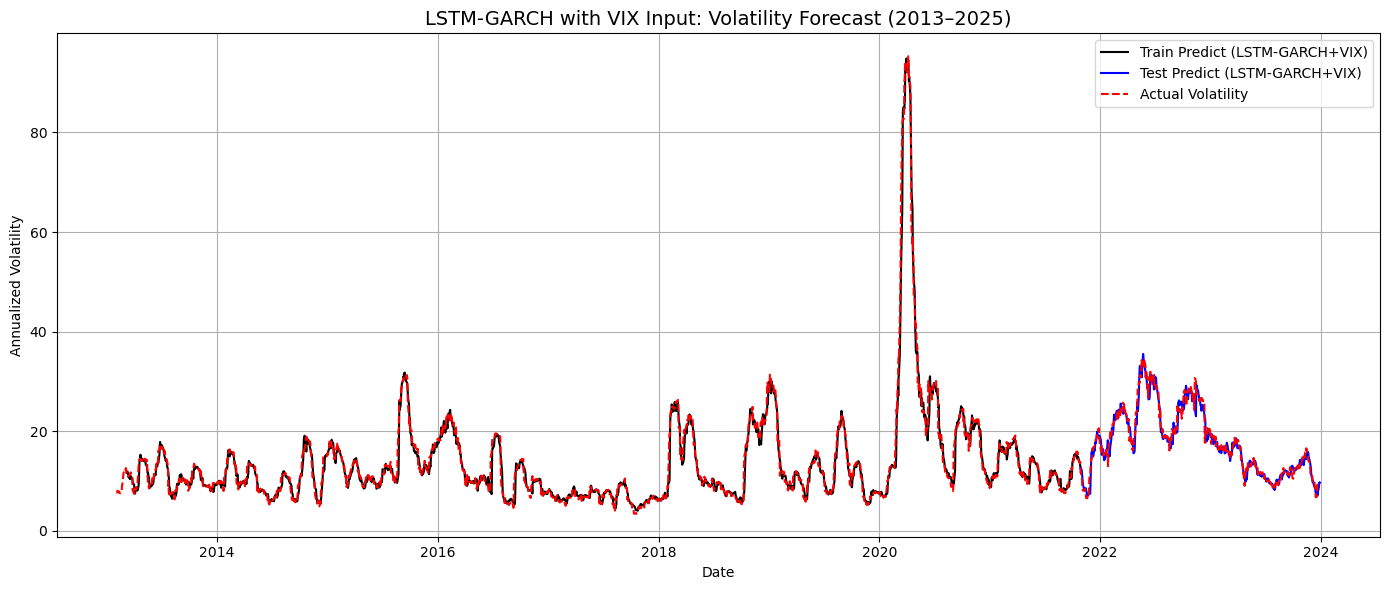

LSTM-GARCH+VIX MAE (Test): 5.9541e-02
LSTM-GARCH+VIX RMSE (Test): 8.2150e-02
LSTM-GARCH+VIX MAE (Train): 4.7926e-02
LSTM-GARCH+VIX RMSE (Train): 7.4963e-02


In [57]:
# LSTM-GARCH+VIX hybrid model — Sample 3 (2013–2025)
hybrid_df_2 = pd.concat([
    returns_2.rename("log_return"),
    volatility_2.shift(1).rename("lagged_vol"),
    garch_std_aligned_2.rename("garch_forecast"),
    vix_2['^VIX'].rename("vix"),
    volatility_2.rename("target_vol")
], axis=1).dropna()

scaler_2 = MinMaxScaler()
scaled_2 = scaler_2.fit_transform(hybrid_df_2)

def create_dataset_2(data, look_back=20):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back, :-1])
        y.append(data[i + look_back, -1])
    return np.array(X), np.array(y)

X_2, y_2 = create_dataset_2(scaled_2, look_back)

split_2 = int(len(X_2) * 0.8)
X_train_2, X_test_2 = X_2[:split_2], X_2[split_2:]
y_train_2, y_test_2 = y_2[:split_2], y_2[split_2:]


model_2 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X_2.shape[2])),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_2.fit(X_train_2, y_train_2, epochs=100, batch_size=64, verbose=0)

y_train_pred_2 = model_2.predict(X_train_2)
y_test_pred_2 = model_2.predict(X_test_2)

scaler_y_2 = MinMaxScaler()
scaler_y_2.min_, scaler_y_2.scale_ = scaler_2.min_[-1], scaler_2.scale_[-1]
train_pred_inv_2 = scaler_y_2.inverse_transform(y_train_pred_2)
test_pred_inv_2 = scaler_y_2.inverse_transform(y_test_pred_2)
y_train_inv_2 = scaler_y_2.inverse_transform(y_train_2.reshape(-1, 1))
y_test_inv_2 = scaler_y_2.inverse_transform(y_test_2.reshape(-1, 1))

full_index_2 = hybrid_df_2.index[look_back + 1:]
train_pred_series_2 = pd.Series(train_pred_inv_2.flatten(), index=full_index_2[:split_2])
test_pred_series_2 = pd.Series(test_pred_inv_2.flatten(), index=full_index_2[split_2:])

plt.figure(figsize=(14, 6))
plt.plot(train_pred_series_2 * math.sqrt(252), label='Train Predict (LSTM-GARCH+VIX)', color='black')
plt.plot(test_pred_series_2 * math.sqrt(252), label='Test Predict (LSTM-GARCH+VIX)', color='blue')
plt.plot(volatility_2 * math.sqrt(252), label='Actual Volatility', linestyle='--', color='red')
plt.title('LSTM-GARCH with VIX Input: Volatility Forecast (2013–2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstm_garch_vix_mae_2013_2025_test = mean_absolute_error(y_test_inv_2, test_pred_inv_2)
lstm_garch_vix_rmse_2013_2025_test = np.sqrt(mean_squared_error(y_test_inv_2, test_pred_inv_2))
lstm_garch_vix_mae_2013_2025_train = mean_absolute_error(y_train_inv_2, train_pred_inv_2)
lstm_garch_vix_rmse_2013_2025_train = np.sqrt(mean_squared_error(y_train_inv_2, train_pred_inv_2))
print(f"LSTM-GARCH+VIX MAE (Test): {lstm_garch_vix_mae_2013_2025_test:.4e}")
print(f"LSTM-GARCH+VIX RMSE (Test): {lstm_garch_vix_rmse_2013_2025_test:.4e}")
print(f"LSTM-GARCH+VIX MAE (Train): {lstm_garch_vix_mae_2013_2025_train:.4e}")
print(f"LSTM-GARCH+VIX RMSE (Train): {lstm_garch_vix_rmse_2013_2025_train:.4e}")

In [ ]:
summary_2000_2025 = pd.DataFrame({
    'Model': ['GARCH', 'LSTM', 'LSTM-GARCH', 'LSTM-GARCH+VIX'],
    'MAE (Train)': [(mae)/100, (lstm_mae_2000_2025_train)/100, (lstm_garch_mae_2000_2025_train)/100, (lstm_garch_vixmae_2000_2025_train)/100],
    'RMSE (Train)': [(rmse)/100, (lstm_rmse_2000_2025_train)/100, (lstm_garch_rmse_2000_2025_train)/100, (lstm_garch_vix_rmse_2000_2025_train)/100],
    'MAE (Test)': [(mae)/100, (lstm_mae_2000_2025_test)/100, (lstm_garch_mae_2000_2025_test)/100, (lstm_garch_vix_mae_2000_2025_test)/100],
    'RMSE (Test)': [(rmse)/100, (lstm_rmse_2000_2025_test)/100, (lstm_garch_rmse_2000_2025_test)/100, (lstm_garch_vix_rmse_2000_2025_test)/100]
})

# Format MAE and RMSE columns to x.xxxe^-2
summary_2000_2025['MAE (Train)'] = summary_2000_2025['MAE (Train)'].apply(lambda x: f'{x:.4e}')
summary_2000_2025['RMSE (Train)'] = summary_2000_2025['RMSE (Train)'].apply(lambda x: f'{x:.4e}')
summary_2000_2025['MAE (Test)'] = summary_2000_2025['MAE (Test)'].apply(lambda x: f'{x:.4e}')
summary_2000_2025['RMSE (Test)'] = summary_2000_2025['RMSE (Test)'].apply(lambda x: f'{x:.4e}')

print("\nSummary Table for 2000-2025 Sample:")
display(summary_2000_2025)

NameError: name 'lstm_garch_vix_mae_2000_2025_train' is not defined

In [ ]:
summary_2000_2012 = pd.DataFrame({
    'Model': ['GARCH', 'LSTM', 'LSTM-GARCH', 'LSTM-GARCH+VIX'],
    'MAE (Train)': [(mae_1)/100, (lstm_mae_2000_2012_train)/100, (lstm_garch_mae_2000_2012_train)/100, (lstm_garch_vix_mae_2000_2012_train)/100],
    'RMSE (Train)': [(rmse_1)/100, (lstm_rmse_2000_2012_train)/100, (lstm_garch_rmse_2000_2012_train)/100, (lstm_garch_vix_rmse_2000_2012_train)/100]
    'MAE (Test)': [(mae_1)/100, (lstm_mae_2000_2012_test)/100, (lstm_garch_mae_2000_2012_test)/100, (lstm_garch_vix_mae_2000_2012_test)/100],
    'RMSE (Test)': [(rmse_1)/100, (lstm_rmse_2000_2012_test)/100, (lstm_garch_rmse_2000_2012_test)/100, (lstm_garch_vix_rmse_2000_2012_test)/100]
})

# Format MAE and RMSE columns to x.xxxe^-2
summary_2000_2012['MAE (Train)'] = summary_2000_2012['MAE (Train)'].apply(lambda x: f'{x:.4e}')
summary_2000_2012['RMSE (Train)'] = summary_2000_2012['RMSE (Train)'].apply(lambda x: f'{x:.4e}')
summary_2000_2012['MAE (Test)'] = summary_2000_2012['MAE (Test)'].apply(lambda x: f'{x:.4e}')
summary_2000_2012['RMSE (Test)'] = summary_2000_2012['RMSE (Test)'].apply(lambda x: f'{x:.4e}')

print("\nSummary Table for 2000-2012 Sample:")
display(summary_2000_2012)

In [ ]:
summary_2013_2025 = pd.DataFrame({
    'Model': ['GARCH', 'LSTM', 'LSTM-GARCH', 'LSTM-GARCH+VIX'],
    'MAE (Train)': [(mae_2)/100, (lstm_mae_2013_2025_train)/100, (lstm_garch_mae_2013_2025_train)/100, (lstm_garch_vix_mae_2013_2025_train)/100],
    'RMSE (Train)': [(rmse_2)/100, (lstm_rmse_2013_2025_train)/100, (lstm_garch_rmse_2013_2025_train)/100, (lstm_garch_vix_rmse_2013_2025_train)/100],
    'MAE (Test)': [(mae_2)/100, (lstm_mae_2013_2025_test)/100, (lstm_garch_mae_2013_2025_test)/100, (lstm_garch_vix_mae_2013_2025_test)/100],
    'RMSE (Test)': [(rmse_2)/100, (lstm_rmse_2013_2025_test)/100, (lstm_garch_rmse_2013_2025_test)/100, (lstm_garch_vix_rmse_2013_2025_test)/100]
})

# Format MAE and RMSE columns to x.xxxe^-2
summary_2013_2025['MAE (Train)'] = summary_2013_2025['MAE (Train)'].apply(lambda x: f'{x:.4e}')
summary_2013_2025['RMSE (Train)'] = summary_2013_2025['RMSE (Train)'].apply(lambda x: f'{x:.4e}')
summary_2013_2025['MAE (Test)'] = summary_2013_2025['MAE (Test)'].apply(lambda x: f'{x:.4e}')
summary_2013_2025['RMSE (Test)'] = summary_2013_2025['RMSE (Test)'].apply(lambda x: f'{x:.4e}')

print("\nSummary Table for 2013-2025 Sample:")
display(summary_2013_2025)

🚩 Approach 1: Quantile Regression Neural Network (QRNN)

In [ ]:
def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.keras.backend.mean(tf.keras.backend.maximum(q * e, (q - 1) * e))

In [ ]:
def train_qrnn(X_train, y_train, quantile, epochs=100, batch_size=64):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.1),
        LSTM(128, activation='tanh'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [ ]:
quantiles = [0.1, 0.5, 0.9]
models = {}

for q in quantiles:
    print(f"Training QRNN for quantile: {q}")
    models[q] = train_qrnn(X_train, y_train, quantile=q)

In [ ]:
qrnn_predictions = {}

for q, model in models.items():
    qrnn_predictions[q] = model.predict(X_test)
    qrnn_predictions[q] = scaler_y.inverse_transform(qrnn_predictions[q])

In [ ]:
# Calculate Pinball Loss for each quantile on the test set
pinball_losses = {}
for q, model in models.items():
    loss = quantile_loss(q, y_test, model.predict(X_test))
    pinball_losses[q] = loss.numpy()

print("Pinball Loss on Test Set:")
for q, loss in pinball_losses.items():
    print(f"Quantile {q}: {loss:.4f}")

In [ ]:
import matplotlib.ticker as mticker

# Calculate per-date Pinball Loss for each quantile on the test set
per_date_pinball_losses = {}
for q, model in models.items():
    # Get predictions for the test set
    predictions = model.predict(X_test)
    # Calculate the error for each date
    errors = y_test - predictions.flatten()
    # Calculate the pinball loss for each date
    per_date_losses = np.maximum(q * errors, (q - 1) * errors)
    per_date_pinball_losses[q] = pd.Series(per_date_losses, index=full_index[split:])

# Plot the per-date Pinball Loss for each quantile in separate graphs
for q, losses in per_date_pinball_losses.items():
    plt.figure(figsize=(14, 7))
    plt.plot(losses / 100, label=f'Pinball Loss (Quantile {q})', alpha=0.7) # Divide losses by 100
    plt.title(f'Per-Date Pinball Loss on Test Set for Quantile {q}')
    plt.xlabel('Date')
    plt.ylabel('Pinball Loss (Scaled by 1/100)') # Update y-axis label
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Set y-axis to scientific notation
    ax = plt.gca()
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2)) # Adjust power limits as needed
    ax.yaxis.set_major_formatter(formatter)

    plt.show()

LSTM-GARCH.

In [ ]:
# Step 1: Prepare Data for LSTM-GARCH-QRNN
# Assumes returns, volatility, and rolling_predictions (GARCH forecast) are already defined

# Merge input data
lstm_garch_qrnn_df = pd.concat([
    returns.rename("log_return"),
    volatility.shift(1).rename("lagged_vol"),
    garch_std_aligned.rename("garch_forecast"),
    volatility.rename("target_vol") # Target variable
], axis=1).dropna()

# Display the head of the created DataFrame
display(lstm_garch_qrnn_df.head())

In [ ]:
def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.keras.backend.mean(tf.keras.backend.maximum(q * e, (q - 1) * e))

def train_lstm_garch_qrnn(X_train, y_train, quantile, look_back, n_features, epochs=100, batch_size=64):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, n_features)),
        Dropout(0.1),
        LSTM(128, activation='tanh'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [ ]:
# Step 3: Train LSTM-GARCH-QRNN Models

# Normalize the prepared data
scaler_lstm_garch_qrnn = MinMaxScaler()
scaled_lstm_garch_qrnn = scaler_lstm_garch_qrnn.fit_transform(lstm_garch_qrnn_df)

# Create dataset for LSTM-GARCH-QRNN
look_back = 20
X_lstm_garch_qrnn, y_lstm_garch_qrnn = [], []
for i in range(len(scaled_lstm_garch_qrnn) - look_back - 1):
    X_lstm_garch_qrnn.append(scaled_lstm_garch_qrnn[i:i + look_back, :-1]) # All columns except target
    y_lstm_garch_qrnn.append(scaled_lstm_garch_qrnn[i + look_back, -1])    # Target is the last column

X_lstm_garch_qrnn = np.array(X_lstm_garch_qrnn)
y_lstm_garch_qrnn = np.array(y_lstm_garch_qrnn)

# Split into train/test sets
split_lstm_garch_qrnn = int(len(X_lstm_garch_qrnn) * 0.8)
X_train_lstm_garch_qrnn, X_test_lstm_garch_qrnn = X_lstm_garch_qrnn[:split_lstm_garch_qrnn], X_lstm_garch_qrnn[split_lstm_garch_qrnn:]
y_train_lstm_garch_qrnn, y_test_lstm_garch_qrnn = y_lstm_garch_qrnn[:split_lstm_garch_qrnn], y_lstm_garch_qrnn[split_lstm_garch_qrnn:]

# Reshape input for LSTM
X_train_lstm_garch_qrnn = X_train_lstm_garch_qrnn.reshape((X_train_lstm_garch_qrnn.shape[0], look_back, X_lstm_garch_qrnn.shape[2]))
X_test_lstm_garch_qrnn = X_test_lstm_garch_qrnn.reshape((X_test_lstm_garch_qrnn.shape[0], look_back, X_lstm_garch_qrnn.shape[2]))

# Train QRNN models for each quantile
quantiles = [0.1, 0.5, 0.9]
lstm_garch_qrnn_models = {}
n_features_lstm_garch_qrnn = X_lstm_garch_qrnn.shape[2]

for q in quantiles:
    print(f"Training LSTM-GARCH-QRNN for quantile: {q}")
    lstm_garch_qrnn_models[q] = train_lstm_garch_qrnn(
        X_train_lstm_garch_qrnn,
        y_train_lstm_garch_qrnn,
        quantile=q,
        look_back=look_back,
        n_features=n_features_lstm_garch_qrnn,
        epochs=100,  # You can adjust epochs
        batch_size=64 # You can adjust batch size
    )

In [ ]:
# Step 4: Calculate Per-Date Pinball Loss for LSTM-GARCH-QRNN

lstm_garch_qrnn_per_date_pinball_losses = {}
# The full_index and split are already defined from the previous QRNN analysis (2000-2025 sample)

for q, model in lstm_garch_qrnn_models.items():
    # Get predictions for the test set using the new model
    predictions = model.predict(X_test_lstm_garch_qrnn)
    # Calculate the error for each date using the new test target
    errors = y_test_lstm_garch_qrnn - predictions.flatten()
    # Calculate the pinball loss for each date
    per_date_losses = np.maximum(q * errors, (q - 1) * errors)
    # Use the correct index for the test set based on the new DataFrame
    lstm_garch_qrnn_per_date_pinball_losses[q] = pd.Series(per_date_losses, index=lstm_garch_qrnn_df.index[split_lstm_garch_qrnn + look_back + 1:])

print("Calculated per-date pinball loss for LSTM-GARCH-QRNN models.")

In [ ]:
# Calculate the mean pinball loss for each quantile on the test set
lstm_garch_qrnn_pinball_losses = {}
for q, losses_series in lstm_garch_qrnn_per_date_pinball_losses.items():
    lstm_garch_qrnn_pinball_losses[q] = losses_series.mean()

print("Average Pinball Loss on Test Set for LSTM-GARCH-QRNN Models:")
for q, loss in lstm_garch_qrnn_pinball_losses.items():
    print(f"Quantile {q}: {loss:.4f}")

In [ ]:
import matplotlib.ticker as mticker

# Step 5: Plot Per-Date Pinball Loss for LSTM-GARCH-QRNN

for q, losses in lstm_garch_qrnn_per_date_pinball_losses.items():
    plt.figure(figsize=(14, 7))
    # Scale losses by 1/100 for plotting
    plt.plot(losses / 100, label=f'Pinball Loss (LSTM-GARCH-QRNN Quantile {q})', alpha=0.7)

    plt.title(f'Per-Date Pinball Loss on Test Set for LSTM-GARCH-QRNN Quantile {q}')
    plt.xlabel('Date')
    plt.ylabel('Pinball Loss (Scaled by 1/100)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Set y-axis to scientific notation
    ax = plt.gca()
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2)) # Adjust power limits as needed
    ax.yaxis.set_major_formatter(formatter)

    plt.show()

In [ ]:
print("Pinball Loss Comparison (LSTM-QRNN vs LSTM-GARCH-QRNN):")

print("\nLSTM-QRNN Pinball Losses:")
for q, loss in pinball_losses.items():
    # Divide loss by 100 and format in scientific notation
    print(f"Quantile {q}: {loss/100:.4e}")

print("\nLSTM-GARCH-QRNN Pinball Losses:")
for q, loss in lstm_garch_qrnn_pinball_losses.items():
    # Divide loss by 100 and format in scientific notation
    print(f"Quantile {q}: {loss/100:.4e}")

# divided by 100 and presented in scientific format.
# this will be in the poster.

🚩 Approach 2: Regime-Switching

## Regime-Switching Volatility Model

Define the regime using Rolling Volatility and include a regime flag as an input feature.


1. Uses a rolling threshold (75th percentile of 1-year volatility) to defind high-volatility "crisis" periods.

2. Creates a binary regime flag:

- 1 = crisis

- 0 = calm

3. Plots the volatility time series, highlighting crisis periods in 'red'.



In [ ]:
# # STEP 1: Construct datetime series (if not already datetime index)
# # Assuming volatility already has a datetime index
# t = volatility.index
# UN = volatility  # daily volatility

# # STEP 2: Define "recession" (crisis) periods using a volatility threshold
# # Calculate the 75th percentile of volatility over a rolling 252-day window (approx. 1 year)
# vol_threshold = volatility.rolling(window=252).quantile(0.75).dropna()

# # Align volatility to match the index of the threshold
# volatility_aligned = volatility.loc[vol_threshold.index]

# # Create regime flag: 1 if volatility > threshold, 0 otherwise
# regime_flag = (volatility_aligned > vol_threshold).astype(int)


# # STEP 3: Plot data with regime bands
# plt.figure(figsize=(14, 6))
# plt.plot(volatility_aligned.index, volatility_aligned, label='Volatility', color='black')

# # Shade crisis (regime = 1) periods
# in_crisis = False
# for i in range(len(regime_flag)):
#     # Access the single value in the Series using .iloc[0]
#     if regime_flag.iloc[i] == 1 and not in_crisis:
#         start = regime_flag.index[i]
#         in_crisis = True
#     elif regime_flag.iloc[i] == 0 and in_crisis:
#         end = regime_flag.index[i]
#         plt.axvspan(start, end, color='red', alpha=0.2)
#         in_crisis = False

# # Check if still in crisis at the end of the data
# if in_crisis:
#     start = None # Reset start for the last segment
#     for i in range(len(regime_flag)):
#       if regime_flag.iloc[i] == 1 and start is None:
#           start = regime_flag.index[i]
#       elif regime_flag.iloc[i] == 0 and start is not None:
#           start = None # Reset start when regime changes

#     if start is not None:
#         end = regime_flag.index[-1]
#         plt.axvspan(start, end, color='red', alpha=0.2)


# plt.title("Volatility with Regime-Switching Crisis Periods (2000–2025)")
# plt.ylabel("Volatility")
# plt.xlabel("Date")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# STEP 1: Construct datetime series (if not already datetime index)
t = volatility.index
UN = volatility  # daily volatility

# STEP 2: Compute rolling quantile thresholds
low_threshold = volatility.rolling(window=252).quantile(0.25).dropna()
high_threshold = volatility.rolling(window=252).quantile(0.75).dropna()

# Align volatility to match thresholds
common_index = low_threshold.index.intersection(high_threshold.index)
volatility_aligned = volatility.loc[common_index]
low_threshold = low_threshold.loc[common_index]
high_threshold = high_threshold.loc[common_index]

# STEP 3: Create 3-level regime flag
regime_flag = pd.Series(index=volatility_aligned.index, dtype=int)
regime_flag[volatility_aligned < low_threshold] = 0     # Low
regime_flag[(volatility_aligned >= low_threshold) & (volatility_aligned <= high_threshold)] = 1  # Medium
regime_flag[volatility_aligned > high_threshold] = 2     # High

# STEP 4: Plot with shaded regions
plt.figure(figsize=(14, 6))
plt.plot(volatility_aligned.index, volatility_aligned, label='Volatility', color='black')

# Define colors for each regime
regime_colors = {0: 'green', 1: 'blue', 2: 'red'}
regime_labels = {0: 'Low Volatility', 1: 'Medium Volatility', 2: 'High Volatility'}

# Shade background by regime
current_regime = regime_flag.iloc[0]
start = regime_flag.index[0]

for i in range(1, len(regime_flag)):
    if regime_flag.iloc[i] != current_regime:
        end = regime_flag.index[i]
        plt.axvspan(start, end, color=regime_colors[current_regime], alpha=0.15, label=regime_labels[current_regime] if start == regime_flag.index[0] else "")
        start = end
        current_regime = regime_flag.iloc[i]

# Final region
plt.axvspan(start, regime_flag.index[-1], color=regime_colors[current_regime], alpha=0.15, label=regime_labels[current_regime] if start == regime_flag.index[0] else "")

plt.title("Volatility with Regime Switching (Low / Medium / High) (2000–2025)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(volatility.quantile(0.25)*math.sqrt(252))
print(volatility.quantile(0.75)*math.sqrt(252))

In [ ]:
# Count the number of data points in each regime
regime_counts = regime_flag.value_counts().sort_index()

# Display the result
print("Regime Counts:")
print(f"Low Volatility (0): {regime_counts.get(0, 0)}")
print(f"Medium Volatility (1): {regime_counts.get(1, 0)}")
print(f"High Volatility (2): {regime_counts.get(2, 0)}")

Option 1: Train LSTM-GARCH Model for Each Regime.

In [ ]:
# Build hybrid dataset
hybrid_df = pd.concat([
    returns.rename("log_return"),
    volatility.shift(1).rename("lagged_vol"),
    garch_std_aligned.rename("garch_forecast"),
    volatility.rename("target_vol"),
    regime_flag.rename("regime_flag")
], axis=1).dropna()

# Split into calm and crisis regimes
low_df = hybrid_df[hybrid_df['regime_flag'] == 0].drop(columns='regime_flag')
med_df = hybrid_df[hybrid_df['regime_flag'] == 1].drop(columns='regime_flag')
high_df = hybrid_df[hybrid_df['regime_flag'] == 2].drop(columns='regime_flag')


# === STEP 2: Train LSTM-GARCH Model per Regime ===
def train_lstm(df, look_back=20):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - look_back - 1):
        X.append(scaled[i:i+look_back])
        y.append(scaled[i+look_back, 3])  # column 3 = target_vol
    X, y = np.array(X), np.array(y)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X.shape[2])),
        Dropout(0.1),
        LSTM(128, activation='tanh'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    return model, scaler, X_test, y_test

model_low, scaler_low, X_test_low, y_test_low = train_lstm(low_df)
model_med, scaler_med, X_test_med, y_test_med = train_lstm(med_df)
model_high, scaler_high, X_test_high, y_test_high = train_lstm(high_df)

# === STEP 3: Evaluate and Plot Results ===
def evaluate_and_plot(model, X_test, y_test, scaler, title, col_index=3):
    y_pred = model.predict(X_test)
    scaler_y = MinMaxScaler()
    scaler_y.min_ = np.array([scaler.min_[col_index]])
    scaler_y.scale_ = np.array([scaler.scale_[col_index]])

    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    plt.figure(figsize=(14, 5))
    plt.plot(y_test_inv, label='Actual', linestyle='--', color='gray')
    plt.plot(y_pred_inv, label='Predicted', color='blue')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{title}:\n  MAE: {mae:.4e}  RMSE: {rmse:.4e}\n")

evaluate_and_plot(model_low, X_test_low, y_test_low, scaler_low, "Low Regime LSTM-GARCH")
evaluate_and_plot(model_med, X_test_med, y_test_med, scaler_med, "Medium Regime LSTM-GARCH")
evaluate_and_plot(model_high, X_test_high, y_test_high, scaler_high, "High Regime LSTM-GARCH")

## Option 2: Train LSTM-GARCH-QRNN Model for Each Regime

In [ ]:
# Step 1: Prepare Data for LSTM-GARCH-QRNN per Regime

# Reuse the hybrid_df created previously which includes returns, lagged_vol, garch_forecast, target_vol, and regime_flag
# The calm_df and crisis_df were also created previously by splitting hybrid_df based on regime_flag

# Display the head of the calm and crisis DataFrames to confirm
print("Low Regime Data (LSTM-GARCH-QRNN input):")
display(low_df.head())

print("\Medium Regime Data (LSTM-GARCH-QRNN input):")
display(med_df.head())

print("\nHigh Regime Data (LSTM-GARCH-QRNN input):")
display(high_df.head())

In [ ]:
# Step 2: Define Training Function for LSTM-GARCH-QRNN per Regime

def train_lstm_garch_qrnn_regime(df, quantile, look_back=20, epochs=100, batch_size=64):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - look_back - 1):
        X.append(scaled[i:i + look_back, :-1]) # All columns except target_vol
        y.append(scaled[i + look_back, -1])    # target_vol is the last column

    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print(f"Warning: Not enough data points to create sequences for look_back={look_back}.")
        return None, None, None, None

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape input for LSTM
    X_train = X_train.reshape((X_train.shape[0], look_back, X.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], look_back, X.shape[2]))

    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, X.shape[2])),
        Dropout(0.1),
        LSTM(128, activation='tanh'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred)) # Reuse quantile_loss function

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    return model, scaler, X_test, y_test, y_train

In [ ]:
# Step 3: Train LSTM-GARCH-QRNN Models per Regime

quantiles = [0.1, 0.5, 0.9]
lstm_garch_qrnn_low_models = {}
lstm_garch_qrnn_med_models = {}
lstm_garch_qrnn_high_models = {}

print("Training LSTM-GARCH-QRNN Models for Low Regime:")
for q in quantiles:
    print(f"  Quantile: {q}")
    model, scaler, X_test, y_test, y_train = train_lstm_garch_qrnn_regime(low_df, quantile=q)
    if model:
        lstm_garch_qrnn_low_models[q] = {
            'model': model,
            'scaler': scaler,
            'X_test': X_test,
            'y_test': y_test,
            'y_train': y_train
        }
print("\nTraining LSTM-GARCH-QRNN Models for Medium Regime:")
for q in quantiles:
    print(f"  Quantile: {q}")
    model, scaler, X_test, y_test, y_train = train_lstm_garch_qrnn_regime(med_df, quantile=q)
    if model:
         lstm_garch_qrnn_med_models[q] = {
            'model': model,
            'scaler': scaler,
            'X_test': X_test,
            'y_test': y_test,
            'y_train': y_train
        }


print("\nTraining LSTM-GARCH-QRNN Models for High Regime:")
for q in quantiles:
    print(f"  Quantile: {q}")
    model, scaler, X_test, y_test, y_train = train_lstm_garch_qrnn_regime(high_df, quantile=q)
    if model:
         lstm_garch_qrnn_high_models[q] = {
            'model': model,
            'scaler': scaler,
            'X_test': X_test,
            'y_test': y_test,
            'y_train': y_train
        }

print("\nLSTM-GARCH-QRNN models trained for each regime and quantile.")

In [ ]:
import matplotlib.ticker as mticker

# === LOW Regime ===
print("\nPlotting Per-Date Pinball Loss for LOW Regime LSTM-GARCH-QRNN Models:")
for q, data in lstm_garch_qrnn_low_models.items():
    model = data['model']
    X_test = data['X_test']
    y_test = data['y_test']
    scaler = data['scaler']

    predictions = model.predict(X_test)
    errors = y_test - predictions.flatten()
    per_date_losses = np.maximum(q * errors, (q - 1) * errors)

    low_df_index = low_df.index[look_back + 1:]
    split_index = int(len(low_df_index) * 0.8)
    test_index = low_df_index[split_index:]
    per_date_pinball_losses = pd.Series(per_date_losses, index=test_index)

    plt.figure(figsize=(14, 7))
    plt.plot(per_date_pinball_losses / 100, label=f'Pinball Loss (Low Regime, Quantile {q})', alpha=0.7)
    plt.title(f'Per-Date Pinball Loss on Test Set for LOW Regime (Quantile {q})')
    plt.xlabel('Date')
    plt.ylabel('Pinball Loss (Scaled by 1/100)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    ax = plt.gca()
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(formatter)
    plt.show()

# === MEDIUM Regime ===
print("\nPlotting Per-Date Pinball Loss for MEDIUM Regime LSTM-GARCH-QRNN Models:")
for q, data in lstm_garch_qrnn_med_models.items():
    model = data['model']
    X_test = data['X_test']
    y_test = data['y_test']
    scaler = data['scaler']

    predictions = model.predict(X_test)
    errors = y_test - predictions.flatten()
    per_date_losses = np.maximum(q * errors, (q - 1) * errors)

    med_df_index = med_df.index[look_back + 1:]
    split_index = int(len(med_df_index) * 0.8)
    test_index = med_df_index[split_index:]
    per_date_pinball_losses = pd.Series(per_date_losses, index=test_index)

    plt.figure(figsize=(14, 7))
    plt.plot(per_date_pinball_losses / 100, label=f'Pinball Loss (Medium Regime, Quantile {q})', alpha=0.7)
    plt.title(f'Per-Date Pinball Loss on Test Set for MEDIUM Regime (Quantile {q})')
    plt.xlabel('Date')
    plt.ylabel('Pinball Loss (Scaled by 1/100)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    ax = plt.gca()
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(formatter)
    plt.show()

# === HIGH Regime ===
print("\nPlotting Per-Date Pinball Loss for HIGH Regime LSTM-GARCH-QRNN Models:")
for q, data in lstm_garch_qrnn_high_models.items():
    model = data['model']
    X_test = data['X_test']
    y_test = data['y_test']
    scaler = data['scaler']

    predictions = model.predict(X_test)
    errors = y_test - predictions.flatten()
    per_date_losses = np.maximum(q * errors, (q - 1) * errors)

    high_df_index = high_df.index[look_back + 1:]
    split_index = int(len(high_df_index) * 0.8)
    test_index = high_df_index[split_index:]
    per_date_pinball_losses = pd.Series(per_date_losses, index=test_index)

    plt.figure(figsize=(14, 7))
    plt.plot(per_date_pinball_losses / 100, label=f'Pinball Loss (High Regime, Quantile {q})', alpha=0.7)
    plt.title(f'Per-Date Pinball Loss on Test Set for HIGH Regime (Quantile {q})')
    plt.xlabel('Date')
    plt.ylabel('Pinball Loss (Scaled by 1/100)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    ax = plt.gca()
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(formatter)
    plt.show()


In [ ]:
# import matplotlib.ticker as mticker

# # Step 5: Plot Per-Date Pinball Loss for LSTM-GARCH-QRNN per Regime

# # Calm Regime
# print("\nPlotting Per-Date Pinball Loss for Calm Regime LSTM-GARCH-QRNN Models:")
# for q, data in lstm_garch_qrnn_low_models.items():
#     model = data['model']
#     X_test = data['X_test']
#     y_test = data['y_test']
#     scaler = data['scaler']

#     # Get predictions for the test set
#     predictions = model.predict(X_test)

#     # Calculate the error for each date using the new test target
#     errors = y_test - predictions.flatten()

#     # Calculate the pinball loss for each date
#     per_date_losses = np.maximum(q * errors, (q - 1) * errors)

#     # Reconstruct the index for the test set for plotting
#     # Find the starting index of the test set within the original calm_df
#     calm_df_index = low_df.index[look_back + 1:]
#     split_index_calm = int(len(calm_df_index) * 0.8)
#     test_index_calm = calm_df_index[split_index_calm:]

#     per_date_pinball_losses_calm = pd.Series(per_date_losses, index=test_index_calm)


#     plt.figure(figsize=(14, 7))
#     # Scale losses by 1/100 for plotting
#     plt.plot(per_date_pinball_losses_calm / 100, label=f'Pinball Loss (Low Regime, Quantile {q})', alpha=0.7)

#     plt.title(f'Per-Date Pinball Loss on Test Set for Calm Regime LSTM-GARCH-QRNN Quantile {q}')
#     plt.xlabel('Date')
#     plt.ylabel('Pinball Loss (Scaled by 1/100)')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()

#     # Set y-axis to scientific notation
#     ax = plt.gca()
#     formatter = mticker.ScalarFormatter(useMathText=True)
#     formatter.set_powerlimits((-2, 2)) # Adjust power limits as needed
#     ax.yaxis.set_major_formatter(formatter)

#     plt.show()

# # Crisis Regime
# print("\nPlotting Per-Date Pinball Loss for Crisis Regime LSTM-GARCH-QRNN Models:")
# for q, data in lstm_garch_qrnn_crisis_models.items():
#     model = data['model']
#     X_test = data['X_test']
#     y_test = data['y_test']
#     scaler = data['scaler']

#     # Get predictions for the test set
#     predictions = model.predict(X_test)

#     # Calculate the error for each date using the new test target
#     errors = y_test - predictions.flatten()

#     # Calculate the pinball loss for each date
#     per_date_losses = np.maximum(q * errors, (q - 1) * errors)

#     # Reconstruct the index for the test set for plotting
#     # Find the starting index of the test set within the original crisis_df
#     crisis_df_index = crisis_df.index[look_back + 1:]
#     split_index_crisis = int(len(crisis_df_index) * 0.8)
#     test_index_crisis = crisis_df_index[split_index_crisis:]

#     per_date_pinball_losses_crisis = pd.Series(per_date_losses, index=test_index_crisis)

#     plt.figure(figsize=(14, 7))
#     # Scale losses by 1/100 for plotting
#     plt.plot(per_date_pinball_losses_crisis / 100, label=f'Pinball Loss (Crisis Regime, Quantile {q})', alpha=0.7)

#     plt.title(f'Per-Date Pinball Loss on Test Set for Crisis Regime LSTM-GARCH-QRNN Quantile {q}')
#     plt.xlabel('Date')
#     plt.ylabel('Pinball Loss (Scaled by 1/100)')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()

#     # Set y-axis to scientific notation
#     ax = plt.gca()
#     formatter = mticker.ScalarFormatter(useMathText=True)
#     formatter.set_powerlimits((-2, 2)) # Adjust power limits as needed
#     ax.yaxis.set_major_formatter(formatter)

#     plt.show()

In [ ]:
print("Pinball Loss Comparison (LSTM-QRNN vs LSTM-GARCH-QRNN):")

print("\nLSTM-QRNN Pinball Losses:")
for q, loss in pinball_losses.items():
    print(f"Quantile {q}: {loss/100:.4e}")

print("\nLSTM-GARCH-QRNN Pinball Losses:")
for q, loss in lstm_garch_qrnn_pinball_losses.items():
    print(f"Quantile {q}: {loss/100:.4e}")


print("\nPinball Loss Evaluation for low Regime LSTM-GARCH-QRNN Models:")
print(f"Quantile {0.1}: {low_pinball_losses[0.1]/100:.4e}")
print(f"Quantile {0.5}: {low_pinball_losses[0.5]/100:.4e}")
print(f"Quantile {0.9}: {low_pinball_losses[0.9]/100:.4e}")


print("\nPinball Loss Evaluation for medium Regime LSTM-GARCH-QRNN Models:")
print(f"Quantile {0.1}: {med_pinball_losses[0.1]/100:.4e}")
print(f"Quantile {0.5}: {med_pinball_losses[0.5]/100:.4e}")
print(f"Quantile {0.5}: {med_pinball_losses[0.9]/100:.4e}")

print("\nPinball Loss Evaluation for high Regime LSTM-GARCH-QRNN Models:")
print(f"Quantile {0.1}: {high_pinball_losses[0.1]/100:.4e}")
print(f"Quantile {0.5}: {high_pinball_losses[0.5]/100:.4e}")
print(f"Quantile {0.5}: {high_pinball_losses[0.9]/100:.4e}")
